In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

## A simple physics model

Suppose we want to simulate the motion of a ball. More specifically, for each time $t$, we would like to know the position, $\vec{x}$ of an object, perhaps under some acceleration $\vec{a}$.

Kinematic equations tell us:
\begin{equation}
\vec{x}(t) = \vec{x}_{0} + \vec{v}_{0}t + \frac{1}{2}\vec{a}t^2
\end{equation}

where $\vec{x}_{0}$ and $\vec{v}_{0}$ are the initial position/velocity.

In code: 

In [2]:
def position(t, a, x0, v0):
    return x0 + v0*t + 0.5*a*t**2

Sticking to 2d for visualization purposes, we can run a simple simulation to get the trajectory of an object under the influence of gravity, namely:

$\vec{a}$ = (0, -9.8), in units of $m / s^2$

In [3]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a = np.asarray([0, -9.8])

#Initial velocity for fun (m / s)
v0 = np.asarray([5, 10])

#Start at (0,10) [m]
x0 = np.asarray([0,10])

We then can create a trajectory for the object by "measuring" position at a set of time steps

In [4]:
#Run the simulation: 100 timesteps
time_steps = np.linspace(0, 5, 100)

trajectory = []
for t_step in time_steps:
    xt = position(t_step, a, x0, v0)
    trajectory.append(xt)
    
trajectory = np.asarray(trajectory)

For fun, let's animate how this might look:

In [5]:
xlim = [trajectory[:, 0].min(), trajectory[:, 0].max()]
ylim = [trajectory[:, 1].min(), trajectory[:, 1].max()]

<IPython.core.display.Javascript object>


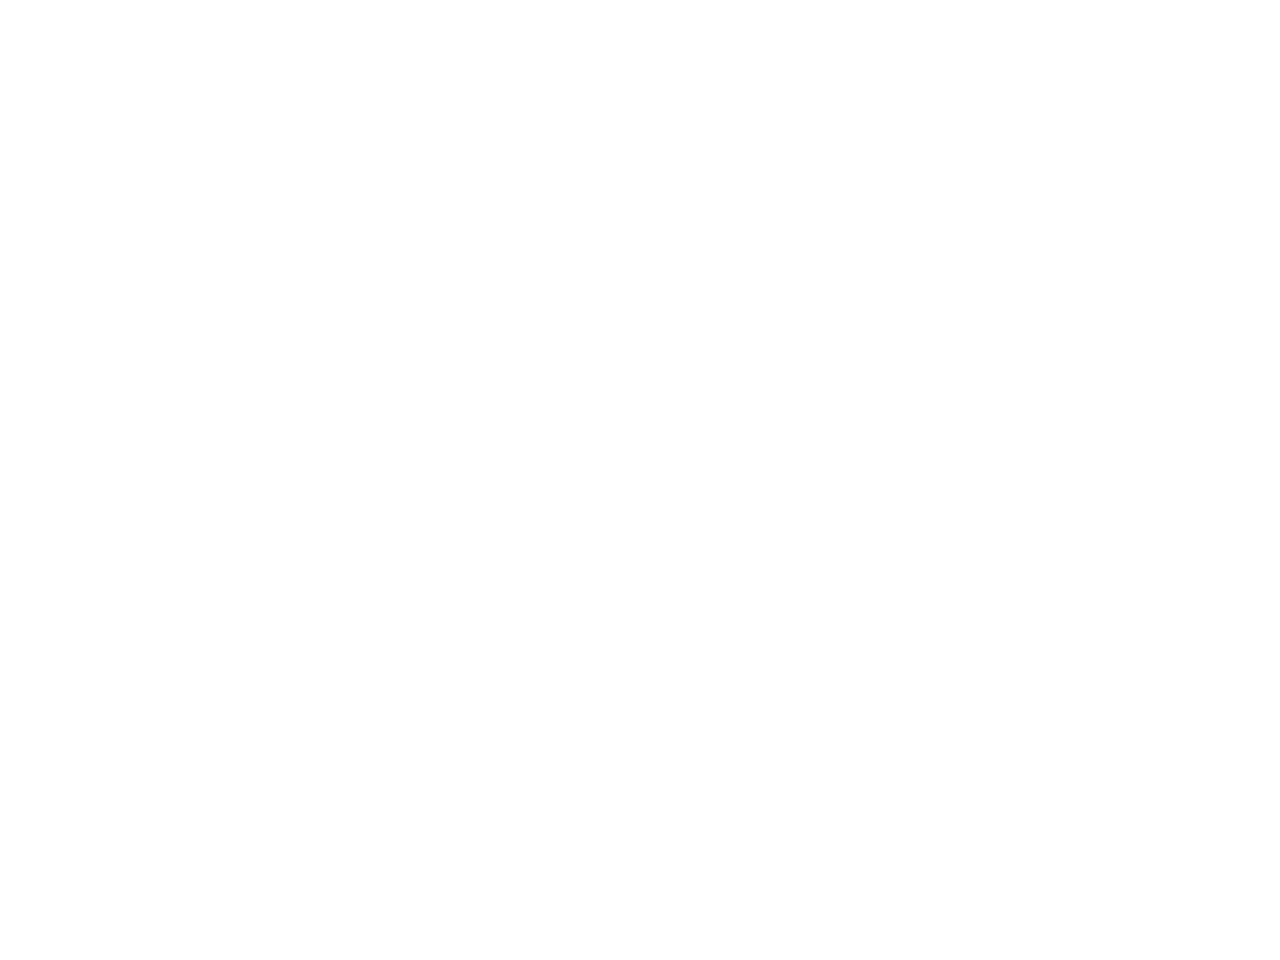

In [6]:
%matplotlib notebook

fig, ax = plt.subplots()

dot, = ax.plot([x0[0]], [x0[1]], 'ro')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

def animate(time_step):
    dot.set_data(trajectory[time_step, 0], trajectory[time_step, 1])
    return dot,

anim = FuncAnimation(fig, animate, frames=len(time_steps), interval=25, repeat=True, blit=True)
plt.show()

Or, just plotting all time steps:

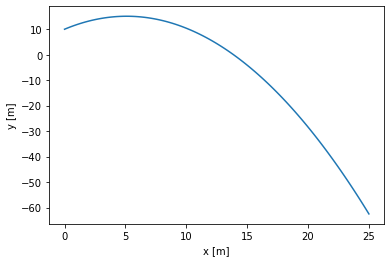

In [7]:
%matplotlib inline
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

We now have a physics simulator (albeit a simple one)! 

### Terminology: 
In the ML context, we call the above simulator our **forward model**, namely: we start from some set of conditions, and we use the forward model to get some result.

### Today: 
Imagine we know the forward model, and we have some dataset. In a real context, this could correspond to experimental data, where the forward model is the physics simulation. How can we use the forward model to gain insight into the experimental data? More particularly, can we use the forward model to extract physical parameters from the real dataset? This is where differentiable simulation can be useful! Notable examples: detector calibration, physics reconstruction.

### In our case:
Suppose we're given some kinematic trajectory, but we don't know the initial velocity? Or the acceleration? Or the initial position? A differentiable kinematics simulator provides an easy tool to extract these parameters. Let's see how this works.

## Step 1: Differentiable forward model

We'll use PyTorch here, but the same concepts apply to any framework

In [8]:
import torch

### Convenience step: Vectorization
In principle, for loops are ok! In practice, it's often more convenient to repackage.

Our data: single 2D kinematic trajectory with measurements at `n_steps` time steps $\implies$ the output of the simulation should have shape `(n_steps, 2)`.

In [9]:
trajectory.shape

(100, 2)

Repeating here for clarity, but: position function can stay the same!

In [10]:
def position(t, a, x0, v0):
    return x0 + v0*t + 0.5*a*t**2

However, we need to adjust the shapes to work.

Think of time as the zeroth dimension, spatial coordinates as the first dimension. Then, if we define our parameters as:

In [11]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a = torch.tensor([0, -9.8])[None, :]

#Initial velocity for fun (m / s)
v0 = torch.tensor([5, 10])[None, :]

#Start at (0,10) [m]
x0 = torch.tensor([0,10])[None, :]

In [12]:
a.shape

torch.Size([1, 2])

and our timesteps as:

In [13]:
#Run the simulation: 100 timesteps
time_steps = torch.linspace(0, 5, 100)[:, None]

In [14]:
time_steps.shape

torch.Size([100, 1])

Broadcasting will then give us the desired shape

In [15]:
trajectory = position(time_steps, a, x0, v0)

In [16]:
print(trajectory.shape)

torch.Size([100, 2])


and we haven't changed any values, so the output should be identical

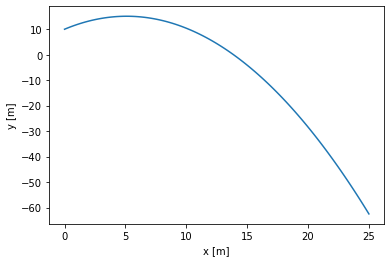

In [17]:
%matplotlib inline
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

### Summary: 

Things are easy for us today! Our forward model is a single function, `position`, which takes in measurement times, acceleration, initial position, and initial velocity, and returns a trajectory ($x$ and $y$ positions at each time step).

Note that this is trivially differentiable -- we only use addition and multiplication! A more complicated simulation might require more tricks, but let's leave that for another day

## Step 2: "Take" some data

For today, we'll be using a single trajectory with some given parameter values as our target. This is the most perfect case -- our forward model is exact and we know the true parameter values. Real life is more complicated, but everybody starts somewhere!

Let's use the same trajectory as above, but recording for posterity:

In [18]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a_target = torch.tensor([0, -9.8])[None, :]

#Initial velocity for fun (m / s)
v0_target = torch.tensor([5, 10])[None, :]

#Start at (0,10) [m]
x0_target = torch.tensor([0,10])[None, :]

#Data taken at 100 known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 100)[:, None]

Target is the corresponding trajectory

In [19]:
trajectory_target = position(time_steps, a_target, x0_target, v0_target)

## Step 3: Set up parameter gradients

To start, let's try to solve for the initial velocity. We need to set up a new forward model with an initial guess. We can then iterate over the new model parameters.


We assume only v0 changes for now, so everything else is the same

In [20]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a_guess = torch.tensor([0, -9.8])[None, :]

#Start at (0,10) [m]
x0_guess = torch.tensor([0.,10.])[None, :]

#Run the simulation: 100 timesteps
time_steps = torch.linspace(0, 5, 100)[:, None]

And we don't know v0, so let's initialize to (0, 0)

In [21]:
#Initial velocity for fun (m / s)
v0_guess = torch.tensor([0., 0.])[None, :]

Now we need a training loop. There are two important pieces:

1. A **loss function**: in this case the easiest is just the Mean Squared Error between the output of the "guess" forward model and the target trajectory.

2. An **optimizer**: how do we change parameters to try to fit the trajectory? Let's start with a simple gradient descent.

Recall that gradient descent for some parameter (or vector of parameters) $\theta$ at training step $i$ has update rule:

\begin{equation}
\theta_{i+1} = \theta_{i} - \eta\cdot\nabla_{\theta}f(\theta_i)
\end{equation}

where $f$ is our objective function, and $\eta$ is a _learning rate_ which controls the size of the gradient step. 

To do gradient descent, we need to keep track of gradients. In PyTorch this is done with setting `requires_grad = True` for the relevant parameters, either as an argument to `torch.tensor` in the initialization, or after the fact, like:

In [22]:
v0_guess.requires_grad = True

Gradients of `v0_guess` are accessible via the attribute `v0_guess.grad`. Right now, `v0_guess` hasn't interacted with the physics model, so this is not filled.

In [23]:
print(v0_guess.grad)

None


## The training loop

There are a few steps in the typical autodiff training loop. First, we need to initialize the parameters we want to fit -- we already did this above, but just to keep everything together, let's repeat.

### Fixed parameters:

In [24]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a_guess = torch.tensor([0, -9.8])[None, :]

#Start at (0,10) [m]
x0_guess = torch.tensor([0.,10.])[None, :]

#Run the simulation: 100 timesteps
time_steps = torch.linspace(0, 5, 100)[:, None]

### Not fixed parameters:
We want to solve for `v0_guess`

In [25]:
#Initial velocity for fun (m / s)
v0_guess = torch.tensor([0., 0.])[None, :]
v0_guess.requires_grad = True

Then we make a guess with the initial parameters. This is done with a simple pass through the forward model

In [26]:
trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)

Then compute the loss between the guessed trajectory and the target

In [27]:
loss = ((trajectory_target - trajectory_guess)**2).mean()

and let PyTorch accumulate gradients with a backward pass. Note that the backward pass starts at the loss calculation -- this is the thing we want to minimize with gradient descent.

In [28]:
loss.backward()

`v0_guess` now has an associated gradient

In [29]:
print(v0_guess.grad)

tensor([[-41.8771, -83.7542]])


and we expect a velocity of order 10, so let's define a learning rate so that our updates are of appropriate size

In [30]:
lr = 0.1

This allows us to actually do the update of `v0_guess`. We don't want to keep track of gradients through this update, so we wrap this in a `with torch.no_grad()`

In [31]:
with torch.no_grad():
    v0_guess -= lr*v0_guess.grad

`v0_guess` now has an updated value, so we can repeat

In [32]:
print(v0_guess)

tensor([[4.1877, 8.3754]], requires_grad=True)


In a loop:

In [33]:
# Initialize training parameters
v0_guess = torch.tensor([0., 0.])[None, :]
v0_guess.requires_grad = True

# Learning rate -- controls the size of the optimization step
lr = 0.1

# Keep track of training and losses 
training_path = []
losses = []

# Do 10 parameter updates
for epoch in range(10):  
    # Guess with current parameters
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Calculate loss
    loss = ((trajectory_target - trajectory_guess)**2).mean()
    
    # Compute gradients
    loss.backward()

    # Update for next loop
    with torch.no_grad():
        v0_guess -= lr*v0_guess.grad
        
    print(f"Iter {epoch}, Loss: {loss.detach().item()}")
    training_path.append(trajectory_guess.detach())
    losses.append(loss.detach())

Iter 0, Loss: 523.4638061523438
Iter 1, Loss: 13.815546989440918
Iter 2, Loss: 344.420166015625
Iter 3, Loss: 639.60791015625
Iter 4, Loss: 117.51748657226562
Iter 5, Loss: 161.00543212890625
Iter 6, Loss: 654.8856201171875
Iter 7, Loss: 291.0216979980469
Iter 8, Loss: 33.176998138427734
Iter 9, Loss: 564.3025512695312


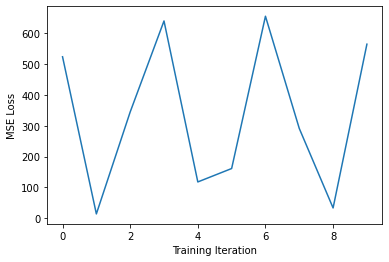

In [34]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

### Uh oh! Something went wrong! The loss should be going down!

But not really -- PyTorch requires you to zero out the gradients after each update, otherwise they accumulate (get summed). This is easily done with:

In [35]:
v0_guess.grad.zero_()

tensor([[0., 0.]])

so that the gradient stored in `v0_guess.grad` corresponds only to each individual forward/backward pass. In the loop, this should be done after every update -- something simple, but a common "first look at autograd" bug!

The proper training loop is then:

In [36]:
# Initialize training parameters
v0_guess = torch.tensor([0., 0.])[None, :]
v0_guess.requires_grad = True

# Learning rate -- controls the size of the optimization step
lr = 0.1

# Keep track of training and losses 
v0_steps = [v0_guess.detach().clone()]
training_path = []
losses = []

# Do 10 parameter updates
for epoch in range(10):   
    # Guess with current parameters
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Calculate loss
    loss = ((trajectory_target - trajectory_guess)**2).mean()
    
    # Compute gradients
    loss.backward()

    print(f"Iter {epoch}, Loss: {loss.detach().item()}")
    
    # Update for next loop
    with torch.no_grad():
        v0_guess -= lr*v0_guess.grad
        
    # Zero out the gradients
    v0_guess.grad.zero_()

    # Store training history.
    training_path.append(trajectory_guess.detach())
    losses.append(loss.detach())
    v0_steps.append(v0_guess.detach().clone())

Iter 0, Loss: 523.4638061523438
Iter 1, Loss: 13.815546989440918
Iter 2, Loss: 0.3646276891231537
Iter 3, Loss: 0.009623640216886997
Iter 4, Loss: 0.00025398950674571097
Iter 5, Loss: 6.708151886414271e-06
Iter 6, Loss: 1.7744775959727122e-07
Iter 7, Loss: 4.587823898560828e-09
Iter 8, Loss: 1.2351669687049593e-10
Iter 9, Loss: 5.973075332954547e-12


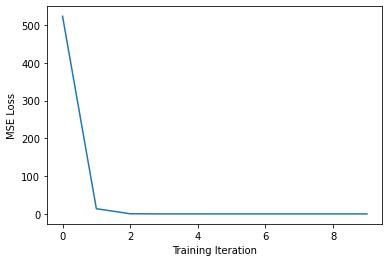

In [37]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

Converges quickly (and looks much healthier)!

Let's look quickly at the training path:

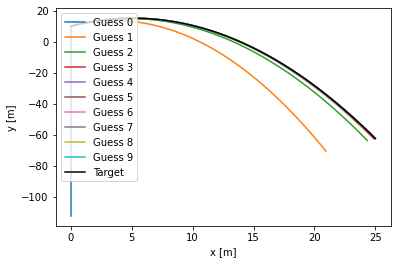

In [38]:
%matplotlib inline
for step, traj in enumerate(training_path):
    plt.plot(traj[:, 0], traj[:, 1], label=f'Guess {step}')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
plt.legend(loc='upper left')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

As expected from the loss, we get closer to the target trajectory with each iteration. Looking at the values of v0:

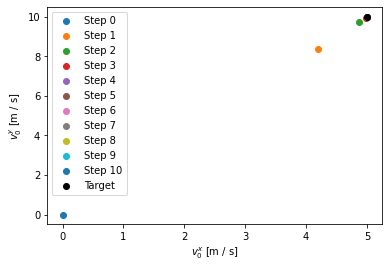

In [39]:
for i_step, step in enumerate(v0_steps):
    plt.scatter(step[:, 0], step[:, 1], label=f'Step {i_step}')
plt.scatter(5, 10, c='k', label='Target')
plt.legend(loc='upper left')
plt.xlabel('$v_{0}^{x}$ [m / s]')
plt.ylabel('$v_{0}^{y}$ [m / s]')
plt.show()

we recover the target parameters.

## Slightly more complicated -- more parameters!

### Exercise:

Let's go crazy and try to fit all parameters: a, x0, and v0. The training loop is basically the same (with a couple of tweaks), just with more things, skeleton provided below:

In [40]:
# Initialize training parameters. This time we want gradients for a, x0, and v0
# Fill in here -- feel free to init to [0, 0]
v0_guess = torch.tensor([0., 0.])[None, :]

# Fill in here
v0_guess.requires_grad = True

# Learning rate -- controls the size of the optimization step
# note, we've decreased it to 0.01 -- more on that in a bit!
lr = 0.01

# Keep track of training and losses 
training_path = []
losses = []

# Do 10000 parameter updates -- do a progress bar to decrease verbosity
# Note that longer training time is needed because we have a smaller learning rate
for epoch in tqdm(range(10000)):  
    # Guess with current parameters
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Calculate loss
    loss = ((trajectory_target - trajectory_guess)**2).mean()
    
    # Compute gradients
    loss.backward()

    #print(f"Iter {epoch}, Loss: {loss.detach().item()}")
    
    # Update for next loop -- simultaneous update of all three
    with torch.no_grad():
        v0_guess -= lr*v0_guess.grad
        # Fill in here: update x0_guess and a_guess with gradient desecent

    # Zero out the gradients
    v0_guess.grad.zero_()
    # Fill in here: need to zero out gradients for x0_guess and a_guess too


    # Store training history.
    training_path.append(trajectory_guess.detach())
    losses.append(loss.detach())

  4%|██████▌                                                                                                                                               | 436/10000 [00:00<00:04, 2211.25it/s]

Iter 0, Loss: 523.4638061523438
Iter 1, Loss: 439.451171875
Iter 2, Loss: 368.922119140625
Iter 3, Loss: 309.7123718261719
Iter 4, Loss: 260.00555419921875
Iter 5, Loss: 218.27630615234375
Iter 6, Loss: 183.2443389892578
Iter 7, Loss: 153.83480834960938
Iter 8, Loss: 129.14529418945312
Iter 9, Loss: 108.41828918457031
Iter 10, Loss: 91.01785278320312
Iter 11, Loss: 76.41004943847656
Iter 12, Loss: 64.14672088623047
Iter 13, Loss: 53.85157775878906
Iter 14, Loss: 45.2087516784668
Iter 15, Loss: 37.953025817871094
Iter 16, Loss: 31.861814498901367
Iter 17, Loss: 26.748191833496094
Iter 18, Loss: 22.455270767211914
Iter 19, Loss: 18.851346969604492
Iter 20, Loss: 15.825827598571777
Iter 21, Loss: 13.285877227783203
Iter 22, Loss: 11.153578758239746
Iter 23, Loss: 9.36349868774414
Iter 24, Loss: 7.860715389251709
Iter 25, Loss: 6.599123954772949
Iter 26, Loss: 5.540002346038818
Iter 27, Loss: 4.650866508483887
Iter 28, Loss: 3.904431104660034
Iter 29, Loss: 3.277792453765869
Iter 30, Loss:

  9%|█████████████▊                                                                                                                                        | 922/10000 [00:00<00:03, 2347.48it/s]

Iter 438, Loss: 1.2351669687049593e-10
Iter 439, Loss: 1.2351669687049593e-10
Iter 440, Loss: 1.2351669687049593e-10
Iter 441, Loss: 1.2351669687049593e-10
Iter 442, Loss: 1.2351669687049593e-10
Iter 443, Loss: 1.2351669687049593e-10
Iter 444, Loss: 1.2351669687049593e-10
Iter 445, Loss: 1.2351669687049593e-10
Iter 446, Loss: 1.2351669687049593e-10
Iter 447, Loss: 1.2351669687049593e-10
Iter 448, Loss: 1.2351669687049593e-10
Iter 449, Loss: 1.2351669687049593e-10
Iter 450, Loss: 1.2351669687049593e-10
Iter 451, Loss: 1.2351669687049593e-10
Iter 452, Loss: 1.2351669687049593e-10
Iter 453, Loss: 1.2351669687049593e-10
Iter 454, Loss: 1.2351669687049593e-10
Iter 455, Loss: 1.2351669687049593e-10
Iter 456, Loss: 1.2351669687049593e-10
Iter 457, Loss: 1.2351669687049593e-10
Iter 458, Loss: 1.2351669687049593e-10
Iter 459, Loss: 1.2351669687049593e-10
Iter 460, Loss: 1.2351669687049593e-10
Iter 461, Loss: 1.2351669687049593e-10
Iter 462, Loss: 1.2351669687049593e-10
Iter 463, Loss: 1.2351669

 14%|████████████████████▊                                                                                                                                | 1396/10000 [00:00<00:03, 2337.82it/s]

Iter 924, Loss: 1.2351669687049593e-10
Iter 925, Loss: 1.2351669687049593e-10
Iter 926, Loss: 1.2351669687049593e-10
Iter 927, Loss: 1.2351669687049593e-10
Iter 928, Loss: 1.2351669687049593e-10
Iter 929, Loss: 1.2351669687049593e-10
Iter 930, Loss: 1.2351669687049593e-10
Iter 931, Loss: 1.2351669687049593e-10
Iter 932, Loss: 1.2351669687049593e-10
Iter 933, Loss: 1.2351669687049593e-10
Iter 934, Loss: 1.2351669687049593e-10
Iter 935, Loss: 1.2351669687049593e-10
Iter 936, Loss: 1.2351669687049593e-10
Iter 937, Loss: 1.2351669687049593e-10
Iter 938, Loss: 1.2351669687049593e-10
Iter 939, Loss: 1.2351669687049593e-10
Iter 940, Loss: 1.2351669687049593e-10
Iter 941, Loss: 1.2351669687049593e-10
Iter 942, Loss: 1.2351669687049593e-10
Iter 943, Loss: 1.2351669687049593e-10
Iter 944, Loss: 1.2351669687049593e-10
Iter 945, Loss: 1.2351669687049593e-10
Iter 946, Loss: 1.2351669687049593e-10
Iter 947, Loss: 1.2351669687049593e-10
Iter 948, Loss: 1.2351669687049593e-10
Iter 949, Loss: 1.2351669

 19%|████████████████████████████▏                                                                                                                        | 1891/10000 [00:00<00:03, 2406.75it/s]

Iter 1396, Loss: 1.2351669687049593e-10
Iter 1397, Loss: 1.2351669687049593e-10
Iter 1398, Loss: 1.2351669687049593e-10
Iter 1399, Loss: 1.2351669687049593e-10
Iter 1400, Loss: 1.2351669687049593e-10
Iter 1401, Loss: 1.2351669687049593e-10
Iter 1402, Loss: 1.2351669687049593e-10
Iter 1403, Loss: 1.2351669687049593e-10
Iter 1404, Loss: 1.2351669687049593e-10
Iter 1405, Loss: 1.2351669687049593e-10
Iter 1406, Loss: 1.2351669687049593e-10
Iter 1407, Loss: 1.2351669687049593e-10
Iter 1408, Loss: 1.2351669687049593e-10
Iter 1409, Loss: 1.2351669687049593e-10
Iter 1410, Loss: 1.2351669687049593e-10
Iter 1411, Loss: 1.2351669687049593e-10
Iter 1412, Loss: 1.2351669687049593e-10
Iter 1413, Loss: 1.2351669687049593e-10
Iter 1414, Loss: 1.2351669687049593e-10
Iter 1415, Loss: 1.2351669687049593e-10
Iter 1416, Loss: 1.2351669687049593e-10
Iter 1417, Loss: 1.2351669687049593e-10
Iter 1418, Loss: 1.2351669687049593e-10
Iter 1419, Loss: 1.2351669687049593e-10
Iter 1420, Loss: 1.2351669687049593e-10


 24%|███████████████████████████████████▊                                                                                                                 | 2405/10000 [00:01<00:03, 2494.39it/s]

Iter 1891, Loss: 1.2351669687049593e-10
Iter 1892, Loss: 1.2351669687049593e-10
Iter 1893, Loss: 1.2351669687049593e-10
Iter 1894, Loss: 1.2351669687049593e-10
Iter 1895, Loss: 1.2351669687049593e-10
Iter 1896, Loss: 1.2351669687049593e-10
Iter 1897, Loss: 1.2351669687049593e-10
Iter 1898, Loss: 1.2351669687049593e-10
Iter 1899, Loss: 1.2351669687049593e-10
Iter 1900, Loss: 1.2351669687049593e-10
Iter 1901, Loss: 1.2351669687049593e-10
Iter 1902, Loss: 1.2351669687049593e-10
Iter 1903, Loss: 1.2351669687049593e-10
Iter 1904, Loss: 1.2351669687049593e-10
Iter 1905, Loss: 1.2351669687049593e-10
Iter 1906, Loss: 1.2351669687049593e-10
Iter 1907, Loss: 1.2351669687049593e-10
Iter 1908, Loss: 1.2351669687049593e-10
Iter 1909, Loss: 1.2351669687049593e-10
Iter 1910, Loss: 1.2351669687049593e-10
Iter 1911, Loss: 1.2351669687049593e-10
Iter 1912, Loss: 1.2351669687049593e-10
Iter 1913, Loss: 1.2351669687049593e-10
Iter 1914, Loss: 1.2351669687049593e-10
Iter 1915, Loss: 1.2351669687049593e-10


 27%|███████████████████████████████████████▌                                                                                                             | 2655/10000 [00:01<00:02, 2479.13it/s]

Iter 2406, Loss: 1.2351669687049593e-10
Iter 2407, Loss: 1.2351669687049593e-10
Iter 2408, Loss: 1.2351669687049593e-10
Iter 2409, Loss: 1.2351669687049593e-10
Iter 2410, Loss: 1.2351669687049593e-10
Iter 2411, Loss: 1.2351669687049593e-10
Iter 2412, Loss: 1.2351669687049593e-10
Iter 2413, Loss: 1.2351669687049593e-10
Iter 2414, Loss: 1.2351669687049593e-10
Iter 2415, Loss: 1.2351669687049593e-10
Iter 2416, Loss: 1.2351669687049593e-10
Iter 2417, Loss: 1.2351669687049593e-10
Iter 2418, Loss: 1.2351669687049593e-10
Iter 2419, Loss: 1.2351669687049593e-10
Iter 2420, Loss: 1.2351669687049593e-10
Iter 2421, Loss: 1.2351669687049593e-10
Iter 2422, Loss: 1.2351669687049593e-10
Iter 2423, Loss: 1.2351669687049593e-10
Iter 2424, Loss: 1.2351669687049593e-10
Iter 2425, Loss: 1.2351669687049593e-10
Iter 2426, Loss: 1.2351669687049593e-10
Iter 2427, Loss: 1.2351669687049593e-10
Iter 2428, Loss: 1.2351669687049593e-10
Iter 2429, Loss: 1.2351669687049593e-10
Iter 2430, Loss: 1.2351669687049593e-10


 31%|██████████████████████████████████████████████▊                                                                                                      | 3144/10000 [00:01<00:03, 2264.45it/s]

Iter 2887, Loss: 1.2351669687049593e-10
Iter 2888, Loss: 1.2351669687049593e-10
Iter 2889, Loss: 1.2351669687049593e-10
Iter 2890, Loss: 1.2351669687049593e-10
Iter 2891, Loss: 1.2351669687049593e-10
Iter 2892, Loss: 1.2351669687049593e-10
Iter 2893, Loss: 1.2351669687049593e-10
Iter 2894, Loss: 1.2351669687049593e-10
Iter 2895, Loss: 1.2351669687049593e-10
Iter 2896, Loss: 1.2351669687049593e-10
Iter 2897, Loss: 1.2351669687049593e-10
Iter 2898, Loss: 1.2351669687049593e-10
Iter 2899, Loss: 1.2351669687049593e-10
Iter 2900, Loss: 1.2351669687049593e-10
Iter 2901, Loss: 1.2351669687049593e-10
Iter 2902, Loss: 1.2351669687049593e-10
Iter 2903, Loss: 1.2351669687049593e-10
Iter 2904, Loss: 1.2351669687049593e-10
Iter 2905, Loss: 1.2351669687049593e-10
Iter 2906, Loss: 1.2351669687049593e-10
Iter 2907, Loss: 1.2351669687049593e-10
Iter 2908, Loss: 1.2351669687049593e-10
Iter 2909, Loss: 1.2351669687049593e-10
Iter 2910, Loss: 1.2351669687049593e-10
Iter 2911, Loss: 1.2351669687049593e-10


 36%|█████████████████████████████████████████████████████▋                                                                                               | 3601/10000 [00:01<00:02, 2205.81it/s]

Iter 3283, Loss: 1.2351669687049593e-10
Iter 3284, Loss: 1.2351669687049593e-10
Iter 3285, Loss: 1.2351669687049593e-10
Iter 3286, Loss: 1.2351669687049593e-10
Iter 3287, Loss: 1.2351669687049593e-10
Iter 3288, Loss: 1.2351669687049593e-10
Iter 3289, Loss: 1.2351669687049593e-10
Iter 3290, Loss: 1.2351669687049593e-10
Iter 3291, Loss: 1.2351669687049593e-10
Iter 3292, Loss: 1.2351669687049593e-10
Iter 3293, Loss: 1.2351669687049593e-10
Iter 3294, Loss: 1.2351669687049593e-10
Iter 3295, Loss: 1.2351669687049593e-10
Iter 3296, Loss: 1.2351669687049593e-10
Iter 3297, Loss: 1.2351669687049593e-10
Iter 3298, Loss: 1.2351669687049593e-10
Iter 3299, Loss: 1.2351669687049593e-10
Iter 3300, Loss: 1.2351669687049593e-10
Iter 3301, Loss: 1.2351669687049593e-10
Iter 3302, Loss: 1.2351669687049593e-10
Iter 3303, Loss: 1.2351669687049593e-10
Iter 3304, Loss: 1.2351669687049593e-10
Iter 3305, Loss: 1.2351669687049593e-10
Iter 3306, Loss: 1.2351669687049593e-10
Iter 3307, Loss: 1.2351669687049593e-10


 41%|█████████████████████████████████████████████████████████████                                                                                        | 4095/10000 [00:01<00:02, 2329.76it/s]

Iter 3738, Loss: 1.2351669687049593e-10
Iter 3739, Loss: 1.2351669687049593e-10
Iter 3740, Loss: 1.2351669687049593e-10
Iter 3741, Loss: 1.2351669687049593e-10
Iter 3742, Loss: 1.2351669687049593e-10
Iter 3743, Loss: 1.2351669687049593e-10
Iter 3744, Loss: 1.2351669687049593e-10
Iter 3745, Loss: 1.2351669687049593e-10
Iter 3746, Loss: 1.2351669687049593e-10
Iter 3747, Loss: 1.2351669687049593e-10
Iter 3748, Loss: 1.2351669687049593e-10
Iter 3749, Loss: 1.2351669687049593e-10
Iter 3750, Loss: 1.2351669687049593e-10
Iter 3751, Loss: 1.2351669687049593e-10
Iter 3752, Loss: 1.2351669687049593e-10
Iter 3753, Loss: 1.2351669687049593e-10
Iter 3754, Loss: 1.2351669687049593e-10
Iter 3755, Loss: 1.2351669687049593e-10
Iter 3756, Loss: 1.2351669687049593e-10
Iter 3757, Loss: 1.2351669687049593e-10
Iter 3758, Loss: 1.2351669687049593e-10
Iter 3759, Loss: 1.2351669687049593e-10
Iter 3760, Loss: 1.2351669687049593e-10
Iter 3761, Loss: 1.2351669687049593e-10
Iter 3762, Loss: 1.2351669687049593e-10


 43%|████████████████████████████████████████████████████████████████▌                                                                                    | 4330/10000 [00:01<00:02, 1943.96it/s]

Iter 4241, Loss: 1.2351669687049593e-10
Iter 4242, Loss: 1.2351669687049593e-10
Iter 4243, Loss: 1.2351669687049593e-10
Iter 4244, Loss: 1.2351669687049593e-10
Iter 4245, Loss: 1.2351669687049593e-10
Iter 4246, Loss: 1.2351669687049593e-10
Iter 4247, Loss: 1.2351669687049593e-10
Iter 4248, Loss: 1.2351669687049593e-10
Iter 4249, Loss: 1.2351669687049593e-10
Iter 4250, Loss: 1.2351669687049593e-10
Iter 4251, Loss: 1.2351669687049593e-10
Iter 4252, Loss: 1.2351669687049593e-10
Iter 4253, Loss: 1.2351669687049593e-10
Iter 4254, Loss: 1.2351669687049593e-10
Iter 4255, Loss: 1.2351669687049593e-10
Iter 4256, Loss: 1.2351669687049593e-10
Iter 4257, Loss: 1.2351669687049593e-10
Iter 4258, Loss: 1.2351669687049593e-10
Iter 4259, Loss: 1.2351669687049593e-10
Iter 4260, Loss: 1.2351669687049593e-10
Iter 4261, Loss: 1.2351669687049593e-10
Iter 4262, Loss: 1.2351669687049593e-10
Iter 4263, Loss: 1.2351669687049593e-10
Iter 4264, Loss: 1.2351669687049593e-10
Iter 4265, Loss: 1.2351669687049593e-10


 48%|███████████████████████████████████████████████████████████████████████▌                                                                             | 4802/10000 [00:02<00:02, 2142.44it/s]

Iter 4519, Loss: 1.2351669687049593e-10
Iter 4520, Loss: 1.2351669687049593e-10
Iter 4521, Loss: 1.2351669687049593e-10
Iter 4522, Loss: 1.2351669687049593e-10
Iter 4523, Loss: 1.2351669687049593e-10
Iter 4524, Loss: 1.2351669687049593e-10
Iter 4525, Loss: 1.2351669687049593e-10
Iter 4526, Loss: 1.2351669687049593e-10
Iter 4527, Loss: 1.2351669687049593e-10
Iter 4528, Loss: 1.2351669687049593e-10
Iter 4529, Loss: 1.2351669687049593e-10
Iter 4530, Loss: 1.2351669687049593e-10
Iter 4531, Loss: 1.2351669687049593e-10
Iter 4532, Loss: 1.2351669687049593e-10
Iter 4533, Loss: 1.2351669687049593e-10
Iter 4534, Loss: 1.2351669687049593e-10
Iter 4535, Loss: 1.2351669687049593e-10
Iter 4536, Loss: 1.2351669687049593e-10
Iter 4537, Loss: 1.2351669687049593e-10
Iter 4538, Loss: 1.2351669687049593e-10
Iter 4539, Loss: 1.2351669687049593e-10
Iter 4540, Loss: 1.2351669687049593e-10
Iter 4541, Loss: 1.2351669687049593e-10
Iter 4542, Loss: 1.2351669687049593e-10
Iter 4543, Loss: 1.2351669687049593e-10


 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                      | 5281/10000 [00:02<00:02, 2146.42it/s]

Iter 5019, Loss: 1.2351669687049593e-10
Iter 5020, Loss: 1.2351669687049593e-10
Iter 5021, Loss: 1.2351669687049593e-10
Iter 5022, Loss: 1.2351669687049593e-10
Iter 5023, Loss: 1.2351669687049593e-10
Iter 5024, Loss: 1.2351669687049593e-10
Iter 5025, Loss: 1.2351669687049593e-10
Iter 5026, Loss: 1.2351669687049593e-10
Iter 5027, Loss: 1.2351669687049593e-10
Iter 5028, Loss: 1.2351669687049593e-10
Iter 5029, Loss: 1.2351669687049593e-10
Iter 5030, Loss: 1.2351669687049593e-10
Iter 5031, Loss: 1.2351669687049593e-10
Iter 5032, Loss: 1.2351669687049593e-10
Iter 5033, Loss: 1.2351669687049593e-10
Iter 5034, Loss: 1.2351669687049593e-10
Iter 5035, Loss: 1.2351669687049593e-10
Iter 5036, Loss: 1.2351669687049593e-10
Iter 5037, Loss: 1.2351669687049593e-10
Iter 5038, Loss: 1.2351669687049593e-10
Iter 5039, Loss: 1.2351669687049593e-10
Iter 5040, Loss: 1.2351669687049593e-10
Iter 5041, Loss: 1.2351669687049593e-10
Iter 5042, Loss: 1.2351669687049593e-10
Iter 5043, Loss: 1.2351669687049593e-10


 57%|█████████████████████████████████████████████████████████████████████████████████████▎                                                               | 5724/10000 [00:02<00:02, 2135.20it/s]

Iter 5417, Loss: 1.2351669687049593e-10
Iter 5418, Loss: 1.2351669687049593e-10
Iter 5419, Loss: 1.2351669687049593e-10
Iter 5420, Loss: 1.2351669687049593e-10
Iter 5421, Loss: 1.2351669687049593e-10
Iter 5422, Loss: 1.2351669687049593e-10
Iter 5423, Loss: 1.2351669687049593e-10
Iter 5424, Loss: 1.2351669687049593e-10
Iter 5425, Loss: 1.2351669687049593e-10
Iter 5426, Loss: 1.2351669687049593e-10
Iter 5427, Loss: 1.2351669687049593e-10
Iter 5428, Loss: 1.2351669687049593e-10
Iter 5429, Loss: 1.2351669687049593e-10
Iter 5430, Loss: 1.2351669687049593e-10
Iter 5431, Loss: 1.2351669687049593e-10
Iter 5432, Loss: 1.2351669687049593e-10
Iter 5433, Loss: 1.2351669687049593e-10
Iter 5434, Loss: 1.2351669687049593e-10
Iter 5435, Loss: 1.2351669687049593e-10
Iter 5436, Loss: 1.2351669687049593e-10
Iter 5437, Loss: 1.2351669687049593e-10
Iter 5438, Loss: 1.2351669687049593e-10
Iter 5439, Loss: 1.2351669687049593e-10
Iter 5440, Loss: 1.2351669687049593e-10
Iter 5441, Loss: 1.2351669687049593e-10


 62%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6222/10000 [00:02<00:01, 2310.55it/s]

Iter 5878, Loss: 1.2351669687049593e-10
Iter 5879, Loss: 1.2351669687049593e-10
Iter 5880, Loss: 1.2351669687049593e-10
Iter 5881, Loss: 1.2351669687049593e-10
Iter 5882, Loss: 1.2351669687049593e-10
Iter 5883, Loss: 1.2351669687049593e-10
Iter 5884, Loss: 1.2351669687049593e-10
Iter 5885, Loss: 1.2351669687049593e-10
Iter 5886, Loss: 1.2351669687049593e-10
Iter 5887, Loss: 1.2351669687049593e-10
Iter 5888, Loss: 1.2351669687049593e-10
Iter 5889, Loss: 1.2351669687049593e-10
Iter 5890, Loss: 1.2351669687049593e-10
Iter 5891, Loss: 1.2351669687049593e-10
Iter 5892, Loss: 1.2351669687049593e-10
Iter 5893, Loss: 1.2351669687049593e-10
Iter 5894, Loss: 1.2351669687049593e-10
Iter 5895, Loss: 1.2351669687049593e-10
Iter 5896, Loss: 1.2351669687049593e-10
Iter 5897, Loss: 1.2351669687049593e-10
Iter 5898, Loss: 1.2351669687049593e-10
Iter 5899, Loss: 1.2351669687049593e-10
Iter 5900, Loss: 1.2351669687049593e-10
Iter 5901, Loss: 1.2351669687049593e-10
Iter 5902, Loss: 1.2351669687049593e-10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6726/10000 [00:02<00:01, 2420.86it/s]

Iter 6371, Loss: 1.2351669687049593e-10
Iter 6372, Loss: 1.2351669687049593e-10
Iter 6373, Loss: 1.2351669687049593e-10
Iter 6374, Loss: 1.2351669687049593e-10
Iter 6375, Loss: 1.2351669687049593e-10
Iter 6376, Loss: 1.2351669687049593e-10
Iter 6377, Loss: 1.2351669687049593e-10
Iter 6378, Loss: 1.2351669687049593e-10
Iter 6379, Loss: 1.2351669687049593e-10
Iter 6380, Loss: 1.2351669687049593e-10
Iter 6381, Loss: 1.2351669687049593e-10
Iter 6382, Loss: 1.2351669687049593e-10
Iter 6383, Loss: 1.2351669687049593e-10
Iter 6384, Loss: 1.2351669687049593e-10
Iter 6385, Loss: 1.2351669687049593e-10
Iter 6386, Loss: 1.2351669687049593e-10
Iter 6387, Loss: 1.2351669687049593e-10
Iter 6388, Loss: 1.2351669687049593e-10
Iter 6389, Loss: 1.2351669687049593e-10
Iter 6390, Loss: 1.2351669687049593e-10
Iter 6391, Loss: 1.2351669687049593e-10
Iter 6392, Loss: 1.2351669687049593e-10
Iter 6393, Loss: 1.2351669687049593e-10
Iter 6394, Loss: 1.2351669687049593e-10
Iter 6395, Loss: 1.2351669687049593e-10


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7219/10000 [00:03<00:01, 2428.63it/s]

Iter 6869, Loss: 1.2351669687049593e-10
Iter 6870, Loss: 1.2351669687049593e-10
Iter 6871, Loss: 1.2351669687049593e-10
Iter 6872, Loss: 1.2351669687049593e-10
Iter 6873, Loss: 1.2351669687049593e-10
Iter 6874, Loss: 1.2351669687049593e-10
Iter 6875, Loss: 1.2351669687049593e-10
Iter 6876, Loss: 1.2351669687049593e-10
Iter 6877, Loss: 1.2351669687049593e-10
Iter 6878, Loss: 1.2351669687049593e-10
Iter 6879, Loss: 1.2351669687049593e-10
Iter 6880, Loss: 1.2351669687049593e-10
Iter 6881, Loss: 1.2351669687049593e-10
Iter 6882, Loss: 1.2351669687049593e-10
Iter 6883, Loss: 1.2351669687049593e-10
Iter 6884, Loss: 1.2351669687049593e-10
Iter 6885, Loss: 1.2351669687049593e-10
Iter 6886, Loss: 1.2351669687049593e-10
Iter 6887, Loss: 1.2351669687049593e-10
Iter 6888, Loss: 1.2351669687049593e-10
Iter 6889, Loss: 1.2351669687049593e-10
Iter 6890, Loss: 1.2351669687049593e-10
Iter 6891, Loss: 1.2351669687049593e-10
Iter 6892, Loss: 1.2351669687049593e-10
Iter 6893, Loss: 1.2351669687049593e-10


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 7726/10000 [00:03<00:00, 2482.34it/s]

Iter 7365, Loss: 1.2351669687049593e-10
Iter 7366, Loss: 1.2351669687049593e-10
Iter 7367, Loss: 1.2351669687049593e-10
Iter 7368, Loss: 1.2351669687049593e-10
Iter 7369, Loss: 1.2351669687049593e-10
Iter 7370, Loss: 1.2351669687049593e-10
Iter 7371, Loss: 1.2351669687049593e-10
Iter 7372, Loss: 1.2351669687049593e-10
Iter 7373, Loss: 1.2351669687049593e-10
Iter 7374, Loss: 1.2351669687049593e-10
Iter 7375, Loss: 1.2351669687049593e-10
Iter 7376, Loss: 1.2351669687049593e-10
Iter 7377, Loss: 1.2351669687049593e-10
Iter 7378, Loss: 1.2351669687049593e-10
Iter 7379, Loss: 1.2351669687049593e-10
Iter 7380, Loss: 1.2351669687049593e-10
Iter 7381, Loss: 1.2351669687049593e-10
Iter 7382, Loss: 1.2351669687049593e-10
Iter 7383, Loss: 1.2351669687049593e-10
Iter 7384, Loss: 1.2351669687049593e-10
Iter 7385, Loss: 1.2351669687049593e-10
Iter 7386, Loss: 1.2351669687049593e-10
Iter 7387, Loss: 1.2351669687049593e-10
Iter 7388, Loss: 1.2351669687049593e-10
Iter 7389, Loss: 1.2351669687049593e-10


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8222/10000 [00:03<00:00, 2457.29it/s]

Iter 7872, Loss: 1.2351669687049593e-10
Iter 7873, Loss: 1.2351669687049593e-10
Iter 7874, Loss: 1.2351669687049593e-10
Iter 7875, Loss: 1.2351669687049593e-10
Iter 7876, Loss: 1.2351669687049593e-10
Iter 7877, Loss: 1.2351669687049593e-10
Iter 7878, Loss: 1.2351669687049593e-10
Iter 7879, Loss: 1.2351669687049593e-10
Iter 7880, Loss: 1.2351669687049593e-10
Iter 7881, Loss: 1.2351669687049593e-10
Iter 7882, Loss: 1.2351669687049593e-10
Iter 7883, Loss: 1.2351669687049593e-10
Iter 7884, Loss: 1.2351669687049593e-10
Iter 7885, Loss: 1.2351669687049593e-10
Iter 7886, Loss: 1.2351669687049593e-10
Iter 7887, Loss: 1.2351669687049593e-10
Iter 7888, Loss: 1.2351669687049593e-10
Iter 7889, Loss: 1.2351669687049593e-10
Iter 7890, Loss: 1.2351669687049593e-10
Iter 7891, Loss: 1.2351669687049593e-10
Iter 7892, Loss: 1.2351669687049593e-10
Iter 7893, Loss: 1.2351669687049593e-10
Iter 7894, Loss: 1.2351669687049593e-10
Iter 7895, Loss: 1.2351669687049593e-10
Iter 7896, Loss: 1.2351669687049593e-10


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8709/10000 [00:03<00:00, 2295.33it/s]

Iter 8356, Loss: 1.2351669687049593e-10
Iter 8357, Loss: 1.2351669687049593e-10
Iter 8358, Loss: 1.2351669687049593e-10
Iter 8359, Loss: 1.2351669687049593e-10
Iter 8360, Loss: 1.2351669687049593e-10
Iter 8361, Loss: 1.2351669687049593e-10
Iter 8362, Loss: 1.2351669687049593e-10
Iter 8363, Loss: 1.2351669687049593e-10
Iter 8364, Loss: 1.2351669687049593e-10
Iter 8365, Loss: 1.2351669687049593e-10
Iter 8366, Loss: 1.2351669687049593e-10
Iter 8367, Loss: 1.2351669687049593e-10
Iter 8368, Loss: 1.2351669687049593e-10
Iter 8369, Loss: 1.2351669687049593e-10
Iter 8370, Loss: 1.2351669687049593e-10
Iter 8371, Loss: 1.2351669687049593e-10
Iter 8372, Loss: 1.2351669687049593e-10
Iter 8373, Loss: 1.2351669687049593e-10
Iter 8374, Loss: 1.2351669687049593e-10
Iter 8375, Loss: 1.2351669687049593e-10
Iter 8376, Loss: 1.2351669687049593e-10
Iter 8377, Loss: 1.2351669687049593e-10
Iter 8378, Loss: 1.2351669687049593e-10
Iter 8379, Loss: 1.2351669687049593e-10
Iter 8380, Loss: 1.2351669687049593e-10


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9164/10000 [00:04<00:00, 2180.56it/s]

Iter 8774, Loss: 1.2351669687049593e-10
Iter 8775, Loss: 1.2351669687049593e-10
Iter 8776, Loss: 1.2351669687049593e-10
Iter 8777, Loss: 1.2351669687049593e-10
Iter 8778, Loss: 1.2351669687049593e-10
Iter 8779, Loss: 1.2351669687049593e-10
Iter 8780, Loss: 1.2351669687049593e-10
Iter 8781, Loss: 1.2351669687049593e-10
Iter 8782, Loss: 1.2351669687049593e-10
Iter 8783, Loss: 1.2351669687049593e-10
Iter 8784, Loss: 1.2351669687049593e-10
Iter 8785, Loss: 1.2351669687049593e-10
Iter 8786, Loss: 1.2351669687049593e-10
Iter 8787, Loss: 1.2351669687049593e-10
Iter 8788, Loss: 1.2351669687049593e-10
Iter 8789, Loss: 1.2351669687049593e-10
Iter 8790, Loss: 1.2351669687049593e-10
Iter 8791, Loss: 1.2351669687049593e-10
Iter 8792, Loss: 1.2351669687049593e-10
Iter 8793, Loss: 1.2351669687049593e-10
Iter 8794, Loss: 1.2351669687049593e-10
Iter 8795, Loss: 1.2351669687049593e-10
Iter 8796, Loss: 1.2351669687049593e-10
Iter 8797, Loss: 1.2351669687049593e-10
Iter 8798, Loss: 1.2351669687049593e-10


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9642/10000 [00:04<00:00, 2291.60it/s]

Iter 9190, Loss: 1.2351669687049593e-10
Iter 9191, Loss: 1.2351669687049593e-10
Iter 9192, Loss: 1.2351669687049593e-10
Iter 9193, Loss: 1.2351669687049593e-10
Iter 9194, Loss: 1.2351669687049593e-10
Iter 9195, Loss: 1.2351669687049593e-10
Iter 9196, Loss: 1.2351669687049593e-10
Iter 9197, Loss: 1.2351669687049593e-10
Iter 9198, Loss: 1.2351669687049593e-10
Iter 9199, Loss: 1.2351669687049593e-10
Iter 9200, Loss: 1.2351669687049593e-10
Iter 9201, Loss: 1.2351669687049593e-10
Iter 9202, Loss: 1.2351669687049593e-10
Iter 9203, Loss: 1.2351669687049593e-10
Iter 9204, Loss: 1.2351669687049593e-10
Iter 9205, Loss: 1.2351669687049593e-10
Iter 9206, Loss: 1.2351669687049593e-10
Iter 9207, Loss: 1.2351669687049593e-10
Iter 9208, Loss: 1.2351669687049593e-10
Iter 9209, Loss: 1.2351669687049593e-10
Iter 9210, Loss: 1.2351669687049593e-10
Iter 9211, Loss: 1.2351669687049593e-10
Iter 9212, Loss: 1.2351669687049593e-10
Iter 9213, Loss: 1.2351669687049593e-10
Iter 9214, Loss: 1.2351669687049593e-10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2297.95it/s]

Iter 9671, Loss: 1.2351669687049593e-10
Iter 9672, Loss: 1.2351669687049593e-10
Iter 9673, Loss: 1.2351669687049593e-10
Iter 9674, Loss: 1.2351669687049593e-10
Iter 9675, Loss: 1.2351669687049593e-10
Iter 9676, Loss: 1.2351669687049593e-10
Iter 9677, Loss: 1.2351669687049593e-10
Iter 9678, Loss: 1.2351669687049593e-10
Iter 9679, Loss: 1.2351669687049593e-10
Iter 9680, Loss: 1.2351669687049593e-10
Iter 9681, Loss: 1.2351669687049593e-10
Iter 9682, Loss: 1.2351669687049593e-10
Iter 9683, Loss: 1.2351669687049593e-10
Iter 9684, Loss: 1.2351669687049593e-10
Iter 9685, Loss: 1.2351669687049593e-10
Iter 9686, Loss: 1.2351669687049593e-10
Iter 9687, Loss: 1.2351669687049593e-10
Iter 9688, Loss: 1.2351669687049593e-10
Iter 9689, Loss: 1.2351669687049593e-10
Iter 9690, Loss: 1.2351669687049593e-10
Iter 9691, Loss: 1.2351669687049593e-10
Iter 9692, Loss: 1.2351669687049593e-10
Iter 9693, Loss: 1.2351669687049593e-10
Iter 9694, Loss: 1.2351669687049593e-10
Iter 9695, Loss: 1.2351669687049593e-10


### Answer:

In [41]:
# Initialize training parameters. This time we want gradients for a, x0, and v0
a_guess = torch.tensor([0., 0.])[None, :]
x0_guess = torch.tensor([0.,0.])[None, :]
v0_guess = torch.tensor([0., 0.])[None, :]

a_guess.requires_grad = True
x0_guess.requires_grad = True
v0_guess.requires_grad = True

# Learning rate -- controls the size of the optimization step
lr = 0.01

# Keep track of training and losses 
training_path = []
losses = []

# Do 10000 parameter updates -- do a progress bar to decrease verbosity
for epoch in tqdm(range(10000)):  
    # Guess with current parameters
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Calculate loss
    loss = ((trajectory_target - trajectory_guess)**2).mean()
    
    # Compute gradients
    loss.backward()

    #print(f"Iter {epoch}, Loss: {loss.detach().item()}")
    
    # Update for next loop -- simultaneous update of all three
    with torch.no_grad():
        v0_guess -= lr*v0_guess.grad
        x0_guess -= lr*x0_guess.grad
        a_guess -= lr*a_guess.grad

    # Zero out the gradients
    v0_guess.grad.zero_()
    x0_guess.grad.zero_()
    a_guess.grad.zero_()


    # Store training history.
    training_path.append(trajectory_guess.detach())
    losses.append(loss.detach())

  0%|                                                                                                                                                                  | 0/10000 [00:00<?, ?it/s]

Iter 0, Loss: 389.73809814453125
Iter 1, Loss: 208.5670166015625
Iter 2, Loss: 142.92076110839844
Iter 3, Loss: 118.4869613647461
Iter 4, Loss: 108.76512908935547
Iter 5, Loss: 104.3047866821289
Iter 6, Loss: 101.7356185913086
Iter 7, Loss: 99.85552978515625
Iter 8, Loss: 98.2356185913086
Iter 9, Loss: 96.72271728515625
Iter 10, Loss: 95.26200103759766
Iter 11, Loss: 93.83370208740234
Iter 12, Loss: 92.43055725097656
Iter 13, Loss: 91.0498046875
Iter 14, Loss: 89.69021606445312
Iter 15, Loss: 88.3511734008789
Iter 16, Loss: 87.03226470947266
Iter 17, Loss: 85.73316192626953
Iter 18, Loss: 84.45352172851562
Iter 19, Loss: 83.19307708740234
Iter 20, Loss: 81.95152282714844
Iter 21, Loss: 80.72858428955078
Iter 22, Loss: 79.52397155761719
Iter 23, Loss: 78.3374252319336
Iter 24, Loss: 77.16865539550781
Iter 25, Loss: 76.01740264892578
Iter 26, Loss: 74.88341522216797
Iter 27, Loss: 73.76641845703125
Iter 28, Loss: 72.6661605834961
Iter 29, Loss: 71.58240509033203
Iter 30, Loss: 70.5148925

  4%|█████▋                                                                                                                                                | 378/10000 [00:00<00:05, 1888.72it/s]

Iter 71, Loss: 38.129798889160156
Iter 72, Loss: 37.563629150390625
Iter 73, Loss: 37.00593566894531
Iter 74, Loss: 36.456600189208984
Iter 75, Loss: 35.915504455566406
Iter 76, Loss: 35.38251495361328
Iter 77, Loss: 34.857505798339844
Iter 78, Loss: 34.340362548828125
Iter 79, Loss: 33.830970764160156
Iter 80, Loss: 33.32920837402344
Iter 81, Loss: 32.834964752197266
Iter 82, Loss: 32.34812545776367
Iter 83, Loss: 31.868579864501953
Iter 84, Loss: 31.39621353149414
Iter 85, Loss: 30.930931091308594
Iter 86, Loss: 30.472618103027344
Iter 87, Loss: 30.021169662475586
Iter 88, Loss: 29.57648277282715
Iter 89, Loss: 29.138460159301758
Iter 90, Loss: 28.706993103027344
Iter 91, Loss: 28.281991958618164
Iter 92, Loss: 27.863357543945312
Iter 93, Loss: 27.45099639892578
Iter 94, Loss: 27.044809341430664
Iter 95, Loss: 26.64470672607422
Iter 96, Loss: 26.250600814819336
Iter 97, Loss: 25.862398147583008
Iter 98, Loss: 25.480003356933594
Iter 99, Loss: 25.10334014892578
Iter 100, Loss: 24.7323

Iter 378, Loss: 0.642284095287323
Iter 379, Loss: 0.6364622712135315
Iter 380, Loss: 0.6307231187820435
Iter 381, Loss: 0.625064492225647
Iter 382, Loss: 0.6194865703582764
Iter 383, Loss: 0.6139878630638123
Iter 384, Loss: 0.6085665225982666
Iter 385, Loss: 0.6032218933105469
Iter 386, Loss: 0.5979524254798889
Iter 387, Loss: 0.5927567481994629
Iter 388, Loss: 0.5876343250274658
Iter 389, Loss: 0.582584023475647
Iter 390, Loss: 0.5776050090789795
Iter 391, Loss: 0.5726956129074097
Iter 392, Loss: 0.5678550601005554
Iter 393, Loss: 0.5630830526351929
Iter 394, Loss: 0.5583770871162415
Iter 395, Loss: 0.5537371039390564
Iter 396, Loss: 0.5491620302200317
Iter 397, Loss: 0.5446512699127197
Iter 398, Loss: 0.5402033925056458
Iter 399, Loss: 0.5358175039291382
Iter 400, Loss: 0.5314919948577881
Iter 401, Loss: 0.5272270441055298
Iter 402, Loss: 0.5230215787887573
Iter 403, Loss: 0.518873929977417
Iter 404, Loss: 0.5147836208343506
Iter 405, Loss: 0.5107502937316895
Iter 406, Loss: 0.506772

  6%|████████▌                                                                                                                                             | 567/10000 [00:00<00:05, 1862.19it/s]

Iter 449, Loss: 0.37840133905410767
Iter 450, Loss: 0.3762091398239136
Iter 451, Loss: 0.3740449547767639
Iter 452, Loss: 0.37190932035446167
Iter 453, Loss: 0.36980143189430237
Iter 454, Loss: 0.36772024631500244
Iter 455, Loss: 0.36566656827926636
Iter 456, Loss: 0.36363884806632996
Iter 457, Loss: 0.36163729429244995
Iter 458, Loss: 0.35966160893440247
Iter 459, Loss: 0.35771065950393677
Iter 460, Loss: 0.35578498244285583
Iter 461, Loss: 0.3538832366466522
Iter 462, Loss: 0.3520064055919647
Iter 463, Loss: 0.35015326738357544
Iter 464, Loss: 0.3483232259750366
Iter 465, Loss: 0.3465162217617035
Iter 466, Loss: 0.34473252296447754
Iter 467, Loss: 0.3429708480834961
Iter 468, Loss: 0.3412315249443054
Iter 469, Loss: 0.3395135998725891
Iter 470, Loss: 0.33781707286834717
Iter 471, Loss: 0.33614209294319153
Iter 472, Loss: 0.3344879150390625
Iter 473, Loss: 0.3328540325164795
Iter 474, Loss: 0.33124101161956787
Iter 475, Loss: 0.3296473026275635
Iter 476, Loss: 0.3280731439590454
Iter 

  8%|███████████▍                                                                                                                                          | 762/10000 [00:00<00:04, 1895.39it/s]

Iter 760, Loss: 0.17217141389846802
Iter 761, Loss: 0.1719377189874649
Iter 762, Loss: 0.17170478403568268
Iter 763, Loss: 0.17147228121757507
Iter 764, Loss: 0.17124034464359283
Iter 765, Loss: 0.17100892961025238
Iter 766, Loss: 0.17077785730361938
Iter 767, Loss: 0.17054736614227295
Iter 768, Loss: 0.17031751573085785
Iter 769, Loss: 0.17008823156356812
Iter 770, Loss: 0.16985918581485748
Iter 771, Loss: 0.1696307212114334
Iter 772, Loss: 0.16940277814865112
Iter 773, Loss: 0.16917520761489868
Iter 774, Loss: 0.16894826292991638
Iter 775, Loss: 0.1687217652797699
Iter 776, Loss: 0.16849574446678162
Iter 777, Loss: 0.1682702600955963
Iter 778, Loss: 0.16804513335227966
Iter 779, Loss: 0.16782066226005554
Iter 780, Loss: 0.16759639978408813
Iter 781, Loss: 0.16737264394760132
Iter 782, Loss: 0.16714954376220703
Iter 783, Loss: 0.1669265329837799
Iter 784, Loss: 0.16670435667037964
Iter 785, Loss: 0.16648225486278534
Iter 786, Loss: 0.16626083850860596
Iter 787, Loss: 0.166039824485778

 10%|██████████████▉                                                                                                                                       | 993/10000 [00:00<00:04, 2042.01it/s]

Iter 846, Loss: 0.15369123220443726
Iter 847, Loss: 0.15349222719669342
Iter 848, Loss: 0.1532936543226242
Iter 849, Loss: 0.15309551358222961
Iter 850, Loss: 0.1528976410627365
Iter 851, Loss: 0.15270012617111206
Iter 852, Loss: 0.15250283479690552
Iter 853, Loss: 0.15230588614940643
Iter 854, Loss: 0.1521093100309372
Iter 855, Loss: 0.15191292762756348
Iter 856, Loss: 0.15171685814857483
Iter 857, Loss: 0.15152116119861603
Iter 858, Loss: 0.15132573246955872
Iter 859, Loss: 0.15113060176372528
Iter 860, Loss: 0.1509358137845993
Iter 861, Loss: 0.15074139833450317
Iter 862, Loss: 0.15054693818092346
Iter 863, Loss: 0.15035317838191986
Iter 864, Loss: 0.15015961229801178
Iter 865, Loss: 0.1499660462141037
Iter 866, Loss: 0.1497730314731598
Iter 867, Loss: 0.14958038926124573
Iter 868, Loss: 0.14938803017139435
Iter 869, Loss: 0.14919579029083252
Iter 870, Loss: 0.14900381863117218
Iter 871, Loss: 0.14881233870983124
Iter 872, Loss: 0.14862100780010223
Iter 873, Loss: 0.1484299749135971

 12%|██████████████████▏                                                                                                                                  | 1220/10000 [00:00<00:04, 2116.82it/s]

Iter 1218, Loss: 0.09574642032384872
Iter 1219, Loss: 0.09562510251998901
Iter 1220, Loss: 0.0955040454864502
Iter 1221, Loss: 0.09538309276103973
Iter 1222, Loss: 0.0952623263001442
Iter 1223, Loss: 0.09514179825782776
Iter 1224, Loss: 0.09502127766609192
Iter 1225, Loss: 0.094900943338871
Iter 1226, Loss: 0.0947808250784874
Iter 1227, Loss: 0.09466078877449036
Iter 1228, Loss: 0.09454092383384705
Iter 1229, Loss: 0.09442131966352463
Iter 1230, Loss: 0.09430170059204102
Iter 1231, Loss: 0.0941823273897171
Iter 1232, Loss: 0.09406311064958572
Iter 1233, Loss: 0.09394402801990509
Iter 1234, Loss: 0.09382496029138565
Iter 1235, Loss: 0.09370627254247665
Iter 1236, Loss: 0.09358759969472885
Iter 1237, Loss: 0.09346915036439896
Iter 1238, Loss: 0.09335077553987503
Iter 1239, Loss: 0.09323254227638245
Iter 1240, Loss: 0.09311456978321075
Iter 1241, Loss: 0.09299670904874802
Iter 1242, Loss: 0.09287895262241364
Iter 1243, Loss: 0.09276138991117477
Iter 1244, Loss: 0.09264396876096725
Iter 12

 14%|█████████████████████▎                                                                                                                               | 1432/10000 [00:00<00:04, 2101.20it/s]

Iter 1297, Loss: 0.0866277813911438
Iter 1298, Loss: 0.0865180492401123
Iter 1299, Loss: 0.08640855550765991
Iter 1300, Loss: 0.08629915863275528
Iter 1301, Loss: 0.08618999272584915
Iter 1302, Loss: 0.08608090132474899
Iter 1303, Loss: 0.0859718769788742
Iter 1304, Loss: 0.08586300909519196
Iter 1305, Loss: 0.08575429767370224
Iter 1306, Loss: 0.08564574271440506
Iter 1307, Loss: 0.08553732186555862
Iter 1308, Loss: 0.08542909473180771
Iter 1309, Loss: 0.08532097935676575
Iter 1310, Loss: 0.08521284908056259
Iter 1311, Loss: 0.08510496467351913
Iter 1312, Loss: 0.0849972814321518
Iter 1313, Loss: 0.08488962799310684
Iter 1314, Loss: 0.0847821831703186
Iter 1315, Loss: 0.08467483520507812
Iter 1316, Loss: 0.08456765860319138
Iter 1317, Loss: 0.08446051925420761
Iter 1318, Loss: 0.08435367792844772
Iter 1319, Loss: 0.08424684405326843
Iter 1320, Loss: 0.08414027094841003
Iter 1321, Loss: 0.08403366804122925
Iter 1322, Loss: 0.08392726629972458
Iter 1323, Loss: 0.08382101356983185
Iter 1

 17%|████████████████████████▊                                                                                                                            | 1663/10000 [00:00<00:03, 2166.58it/s]

Iter 1658, Loss: 0.054834622889757156
Iter 1659, Loss: 0.054765161126852036
Iter 1660, Loss: 0.054695822298526764
Iter 1661, Loss: 0.05462661758065224
Iter 1662, Loss: 0.0545574426651001
Iter 1663, Loss: 0.05448833480477333
Iter 1664, Loss: 0.05441936478018761
Iter 1665, Loss: 0.05435049533843994
Iter 1666, Loss: 0.05428169295191765
Iter 1667, Loss: 0.05421294644474983
Iter 1668, Loss: 0.054144348949193954
Iter 1669, Loss: 0.05407583341002464
Iter 1670, Loss: 0.05400732904672623
Iter 1671, Loss: 0.05393899604678154
Iter 1672, Loss: 0.053870610892772675
Iter 1673, Loss: 0.05380247160792351
Iter 1674, Loss: 0.053734324872493744
Iter 1675, Loss: 0.05366634950041771
Iter 1676, Loss: 0.05359843373298645
Iter 1677, Loss: 0.053530607372522354
Iter 1678, Loss: 0.05346273258328438
Iter 1679, Loss: 0.053395114839076996
Iter 1680, Loss: 0.053327497094869614
Iter 1681, Loss: 0.05326006934046745
Iter 1682, Loss: 0.05319260433316231
Iter 1683, Loss: 0.0531252957880497
Iter 1684, Loss: 0.053058005869

 19%|████████████████████████████▏                                                                                                                        | 1889/10000 [00:00<00:03, 2194.61it/s]

Iter 1743, Loss: 0.04923711344599724
Iter 1744, Loss: 0.04917481914162636
Iter 1745, Loss: 0.049112606793642044
Iter 1746, Loss: 0.04905035346746445
Iter 1747, Loss: 0.04898826777935028
Iter 1748, Loss: 0.04892624914646149
Iter 1749, Loss: 0.04886433482170105
Iter 1750, Loss: 0.048802450299263
Iter 1751, Loss: 0.04874070733785629
Iter 1752, Loss: 0.048678990453481674
Iter 1753, Loss: 0.048617299646139145
Iter 1754, Loss: 0.048555728048086166
Iter 1755, Loss: 0.04849435016512871
Iter 1756, Loss: 0.048432908952236176
Iter 1757, Loss: 0.04837164282798767
Iter 1758, Loss: 0.048310380429029465
Iter 1759, Loss: 0.048249274492263794
Iter 1760, Loss: 0.04818815737962723
Iter 1761, Loss: 0.04812721163034439
Iter 1762, Loss: 0.04806624725461006
Iter 1763, Loss: 0.04800537973642349
Iter 1764, Loss: 0.04794460907578468
Iter 1765, Loss: 0.047883935272693634
Iter 1766, Loss: 0.04782332479953766
Iter 1767, Loss: 0.04776281490921974
Iter 1768, Loss: 0.04770224168896675
Iter 1769, Loss: 0.0476419366896

 21%|███████████████████████████████▍                                                                                                                     | 2111/10000 [00:01<00:03, 2200.84it/s]

Iter 2108, Loss: 0.03100951947271824
Iter 2109, Loss: 0.03097030334174633
Iter 2110, Loss: 0.03093106672167778
Iter 2111, Loss: 0.03089188039302826
Iter 2112, Loss: 0.030852802097797394
Iter 2113, Loss: 0.03081376850605011
Iter 2114, Loss: 0.030774760991334915
Iter 2115, Loss: 0.03073575533926487
Iter 2116, Loss: 0.030696863308548927
Iter 2117, Loss: 0.030657963827252388
Iter 2118, Loss: 0.03061923198401928
Iter 2119, Loss: 0.030580410733819008
Iter 2120, Loss: 0.03054174967110157
Iter 2121, Loss: 0.030503053218126297
Iter 2122, Loss: 0.03046443872153759
Iter 2123, Loss: 0.030425939708948135
Iter 2124, Loss: 0.030387360602617264
Iter 2125, Loss: 0.030348915606737137
Iter 2126, Loss: 0.030310487374663353
Iter 2127, Loss: 0.030272116884589195
Iter 2128, Loss: 0.030233824625611305
Iter 2129, Loss: 0.030195558443665504
Iter 2130, Loss: 0.03015732951462269
Iter 2131, Loss: 0.030119122937321663
Iter 2132, Loss: 0.030081015080213547
Iter 2133, Loss: 0.030042920261621475
Iter 2134, Loss: 0.030

 23%|██████████████████████████████████▊                                                                                                                  | 2335/10000 [00:01<00:03, 2210.53it/s]

Iter 2194, Loss: 0.027808818966150284
Iter 2195, Loss: 0.027773624286055565
Iter 2196, Loss: 0.02773846872150898
Iter 2197, Loss: 0.027703333646059036
Iter 2198, Loss: 0.027668291702866554
Iter 2199, Loss: 0.02763323485851288
Iter 2200, Loss: 0.027598246932029724
Iter 2201, Loss: 0.02756328135728836
Iter 2202, Loss: 0.02752842754125595
Iter 2203, Loss: 0.027493586763739586
Iter 2204, Loss: 0.02745877020061016
Iter 2205, Loss: 0.02742403745651245
Iter 2206, Loss: 0.027389302849769592
Iter 2207, Loss: 0.02735462412238121
Iter 2208, Loss: 0.027319978922605515
Iter 2209, Loss: 0.02728535607457161
Iter 2210, Loss: 0.027250861749053
Iter 2211, Loss: 0.027216384187340736
Iter 2212, Loss: 0.027181925252079964
Iter 2213, Loss: 0.027147548273205757
Iter 2214, Loss: 0.027113134041428566
Iter 2215, Loss: 0.027078866958618164
Iter 2216, Loss: 0.027044568210840225
Iter 2217, Loss: 0.027010321617126465
Iter 2218, Loss: 0.02697615697979927
Iter 2219, Loss: 0.02694196067750454
Iter 2220, Loss: 0.026907

 26%|██████████████████████████████████████▏                                                                                                              | 2560/10000 [00:01<00:03, 2221.99it/s]

Iter 2557, Loss: 0.017558490857481956
Iter 2558, Loss: 0.01753622479736805
Iter 2559, Loss: 0.017514027655124664
Iter 2560, Loss: 0.01749182678759098
Iter 2561, Loss: 0.017469681799411774
Iter 2562, Loss: 0.017447583377361298
Iter 2563, Loss: 0.01742546074092388
Iter 2564, Loss: 0.017403436824679375
Iter 2565, Loss: 0.01738138683140278
Iter 2566, Loss: 0.0173594132065773
Iter 2567, Loss: 0.017337406054139137
Iter 2568, Loss: 0.017315475270152092
Iter 2569, Loss: 0.017293579876422882
Iter 2570, Loss: 0.017271673306822777
Iter 2571, Loss: 0.017249783501029015
Iter 2572, Loss: 0.01722797192633152
Iter 2573, Loss: 0.01720615103840828
Iter 2574, Loss: 0.017184384167194366
Iter 2575, Loss: 0.017162639647722244
Iter 2576, Loss: 0.01714089699089527
Iter 2577, Loss: 0.017119215801358223
Iter 2578, Loss: 0.01709756813943386
Iter 2579, Loss: 0.017075879499316216
Iter 2580, Loss: 0.0170542374253273
Iter 2581, Loss: 0.017032699659466743
Iter 2582, Loss: 0.017011094838380814
Iter 2583, Loss: 0.01698

 28%|█████████████████████████████████████████▋                                                                                                           | 2794/10000 [00:01<00:03, 2254.77it/s]

Iter 2643, Loss: 0.015746179968118668
Iter 2644, Loss: 0.015726279467344284
Iter 2645, Loss: 0.015706341713666916
Iter 2646, Loss: 0.015686457976698875
Iter 2647, Loss: 0.015666622668504715
Iter 2648, Loss: 0.01564677059650421
Iter 2649, Loss: 0.015626946464180946
Iter 2650, Loss: 0.015607165172696114
Iter 2651, Loss: 0.015587435103952885
Iter 2652, Loss: 0.015567738562822342
Iter 2653, Loss: 0.015548012219369411
Iter 2654, Loss: 0.015528339892625809
Iter 2655, Loss: 0.015508699230849743
Iter 2656, Loss: 0.015489054843783379
Iter 2657, Loss: 0.015469435602426529
Iter 2658, Loss: 0.015449868515133858
Iter 2659, Loss: 0.015430284664034843
Iter 2660, Loss: 0.015410738997161388
Iter 2661, Loss: 0.015391248278319836
Iter 2662, Loss: 0.015371773391962051
Iter 2663, Loss: 0.015352334827184677
Iter 2664, Loss: 0.015332890674471855
Iter 2665, Loss: 0.015313493087887764
Iter 2666, Loss: 0.015294092707335949
Iter 2667, Loss: 0.015274732373654842
Iter 2668, Loss: 0.015255359001457691
Iter 2669, Lo

 30%|████████████████████████████████████████████▉                                                                                                        | 3020/10000 [00:01<00:03, 2249.25it/s]

Iter 3016, Loss: 0.009817083366215229
Iter 3017, Loss: 0.009804612025618553
Iter 3018, Loss: 0.009792189113795757
Iter 3019, Loss: 0.009779795072972775
Iter 3020, Loss: 0.009767423383891582
Iter 3021, Loss: 0.009755069389939308
Iter 3022, Loss: 0.009742733091115952
Iter 3023, Loss: 0.009730381891131401
Iter 3024, Loss: 0.009718086570501328
Iter 3025, Loss: 0.009705784730613232
Iter 3026, Loss: 0.009693523868918419
Iter 3027, Loss: 0.009681262075901031
Iter 3028, Loss: 0.009668943472206593
Iter 3029, Loss: 0.00965670682489872
Iter 3030, Loss: 0.009644501842558384
Iter 3031, Loss: 0.009632283821702003
Iter 3032, Loss: 0.009620093740522861
Iter 3033, Loss: 0.009607935324311256
Iter 3034, Loss: 0.009595791809260845
Iter 3035, Loss: 0.00958362314850092
Iter 3036, Loss: 0.009571513161063194
Iter 3037, Loss: 0.009559393860399723
Iter 3038, Loss: 0.009547272697091103
Iter 3039, Loss: 0.00953519158065319
Iter 3040, Loss: 0.00952313281595707
Iter 3041, Loss: 0.00951105635613203
Iter 3042, Loss: 

 32%|████████████████████████████████████████████████▎                                                                                                    | 3245/10000 [00:01<00:03, 2249.07it/s]

Iter 3103, Loss: 0.008792699314653873
Iter 3104, Loss: 0.008781570009887218
Iter 3105, Loss: 0.008770453743636608
Iter 3106, Loss: 0.008759367279708385
Iter 3107, Loss: 0.008748291991651058
Iter 3108, Loss: 0.00873718410730362
Iter 3109, Loss: 0.00872613675892353
Iter 3110, Loss: 0.008715100586414337
Iter 3111, Loss: 0.008704060688614845
Iter 3112, Loss: 0.008693038485944271
Iter 3113, Loss: 0.008682042360305786
Iter 3114, Loss: 0.008671036921441555
Iter 3115, Loss: 0.008660085499286652
Iter 3116, Loss: 0.008649121969938278
Iter 3117, Loss: 0.008638174273073673
Iter 3118, Loss: 0.008627256378531456
Iter 3119, Loss: 0.008616344071924686
Iter 3120, Loss: 0.008605406619608402
Iter 3121, Loss: 0.008594498038291931
Iter 3122, Loss: 0.008583653718233109
Iter 3123, Loss: 0.0085727758705616
Iter 3124, Loss: 0.008561930619180202
Iter 3125, Loss: 0.008551093749701977
Iter 3126, Loss: 0.00854029692709446
Iter 3127, Loss: 0.00852946937084198
Iter 3128, Loss: 0.008518640883266926
Iter 3129, Loss: 0

 35%|███████████████████████████████████████████████████▋                                                                                                 | 3470/10000 [00:01<00:02, 2227.79it/s]

Iter 3461, Loss: 0.005587130784988403
Iter 3462, Loss: 0.00558006577193737
Iter 3463, Loss: 0.00557297095656395
Iter 3464, Loss: 0.005565923638641834
Iter 3465, Loss: 0.0055588725954294205
Iter 3466, Loss: 0.005551840178668499
Iter 3467, Loss: 0.005544800311326981
Iter 3468, Loss: 0.005537789314985275
Iter 3469, Loss: 0.005530781112611294
Iter 3470, Loss: 0.005523798521608114
Iter 3471, Loss: 0.0055168126709759235
Iter 3472, Loss: 0.005509840790182352
Iter 3473, Loss: 0.005502866581082344
Iter 3474, Loss: 0.0054958839900791645
Iter 3475, Loss: 0.005488951690495014
Iter 3476, Loss: 0.005482004955410957
Iter 3477, Loss: 0.005475065670907497
Iter 3478, Loss: 0.0054681370966136456
Iter 3479, Loss: 0.005461197346448898
Iter 3480, Loss: 0.005454282741993666
Iter 3481, Loss: 0.005447378382086754
Iter 3482, Loss: 0.005440481938421726
Iter 3483, Loss: 0.005433599930256605
Iter 3484, Loss: 0.0054267155937850475
Iter 3485, Loss: 0.005419844761490822
Iter 3486, Loss: 0.005412991624325514
Iter 3487

 37%|███████████████████████████████████████████████████████                                                                                              | 3693/10000 [00:01<00:02, 2209.71it/s]

Iter 3536, Loss: 0.005080840550363064
Iter 3537, Loss: 0.005074397195130587
Iter 3538, Loss: 0.00506800040602684
Iter 3539, Loss: 0.005061573348939419
Iter 3540, Loss: 0.00505515793338418
Iter 3541, Loss: 0.005048773251473904
Iter 3542, Loss: 0.005042368080466986
Iter 3543, Loss: 0.005036009009927511
Iter 3544, Loss: 0.005029608495533466
Iter 3545, Loss: 0.005023233126848936
Iter 3546, Loss: 0.005016871728003025
Iter 3547, Loss: 0.005010517779737711
Iter 3548, Loss: 0.005004184786230326
Iter 3549, Loss: 0.004997839219868183
Iter 3550, Loss: 0.004991510417312384
Iter 3551, Loss: 0.0049851988442242146
Iter 3552, Loss: 0.0049788691103458405
Iter 3553, Loss: 0.004972598981112242
Iter 3554, Loss: 0.004966309759765863
Iter 3555, Loss: 0.004959993530064821
Iter 3556, Loss: 0.00495373597368598
Iter 3557, Loss: 0.004947465378791094
Iter 3558, Loss: 0.004941200837492943
Iter 3559, Loss: 0.004934953060001135
Iter 3560, Loss: 0.004928704351186752
Iter 3561, Loss: 0.004922456108033657
Iter 3562, Lo

 39%|██████████████████████████████████████████████████████████▍                                                                                          | 3924/10000 [00:01<00:02, 2236.80it/s]

Iter 3909, Loss: 0.0031677978113293648
Iter 3910, Loss: 0.003163787769153714
Iter 3911, Loss: 0.0031597865745425224
Iter 3912, Loss: 0.0031557963229715824
Iter 3913, Loss: 0.0031517816241830587
Iter 3914, Loss: 0.003147799987345934
Iter 3915, Loss: 0.003143810899928212
Iter 3916, Loss: 0.0031398478895425797
Iter 3917, Loss: 0.003135866718366742
Iter 3918, Loss: 0.003131893463432789
Iter 3919, Loss: 0.003127927193418145
Iter 3920, Loss: 0.0031239583622664213
Iter 3921, Loss: 0.0031200202647596598
Iter 3922, Loss: 0.00311605934984982
Iter 3923, Loss: 0.0031121193896979094
Iter 3924, Loss: 0.003108169184997678
Iter 3925, Loss: 0.003104227827861905
Iter 3926, Loss: 0.0031002950854599476
Iter 3927, Loss: 0.0030963928438723087
Iter 3928, Loss: 0.0030924647580832243
Iter 3929, Loss: 0.003088532015681267
Iter 3930, Loss: 0.0030846407171338797
Iter 3931, Loss: 0.0030807426664978266
Iter 3932, Loss: 0.0030768460128456354
Iter 3933, Loss: 0.003072940045967698
Iter 3934, Loss: 0.003069072961807251

 42%|█████████████████████████████████████████████████████████████▉                                                                                       | 4161/10000 [00:01<00:02, 2273.82it/s]

Iter 3998, Loss: 0.0028300846461206675
Iter 3999, Loss: 0.002826506504788995
Iter 4000, Loss: 0.0028229185845702887
Iter 4001, Loss: 0.0028193530160933733
Iter 4002, Loss: 0.002815788611769676
Iter 4003, Loss: 0.0028122204821556807
Iter 4004, Loss: 0.0028086802922189236
Iter 4005, Loss: 0.002805121475830674
Iter 4006, Loss: 0.0028015479911118746
Iter 4007, Loss: 0.0027980273589491844
Iter 4008, Loss: 0.00279450137168169
Iter 4009, Loss: 0.002790950471535325
Iter 4010, Loss: 0.002787431702017784
Iter 4011, Loss: 0.002783898962661624
Iter 4012, Loss: 0.0027803622651845217
Iter 4013, Loss: 0.00277684535831213
Iter 4014, Loss: 0.0027733298484236
Iter 4015, Loss: 0.002769806422293186
Iter 4016, Loss: 0.0027663172222673893
Iter 4017, Loss: 0.002762800082564354
Iter 4018, Loss: 0.0027593164704740047
Iter 4019, Loss: 0.002755817724391818
Iter 4020, Loss: 0.002752309199422598
Iter 4021, Loss: 0.0027488323394209146
Iter 4022, Loss: 0.0027453461661934853
Iter 4023, Loss: 0.002741890260949731
Iter

 44%|█████████████████████████████████████████████████████████████████▍                                                                                   | 4389/10000 [00:02<00:02, 2255.87it/s]

Iter 4369, Loss: 0.001769020687788725
Iter 4370, Loss: 0.001766780624166131
Iter 4371, Loss: 0.0017645463813096285
Iter 4372, Loss: 0.0017623178428038955
Iter 4373, Loss: 0.0017600874416530132
Iter 4374, Loss: 0.0017578655388206244
Iter 4375, Loss: 0.001755636534653604
Iter 4376, Loss: 0.0017534226644784212
Iter 4377, Loss: 0.0017511968035250902
Iter 4378, Loss: 0.0017489823512732983
Iter 4379, Loss: 0.0017467717407271266
Iter 4380, Loss: 0.00174456718377769
Iter 4381, Loss: 0.0017423656536266208
Iter 4382, Loss: 0.0017401635413989425
Iter 4383, Loss: 0.0017379432683810592
Iter 4384, Loss: 0.0017357507022097707
Iter 4385, Loss: 0.001733554876409471
Iter 4386, Loss: 0.0017313428688794374
Iter 4387, Loss: 0.0017291672993451357
Iter 4388, Loss: 0.0017269739182665944
Iter 4389, Loss: 0.0017247898504137993
Iter 4390, Loss: 0.001722595072351396
Iter 4391, Loss: 0.0017204232281073928
Iter 4392, Loss: 0.0017182482406497002
Iter 4393, Loss: 0.0017160543939098716
Iter 4394, Loss: 0.0017138816183

 46%|████████████████████████████████████████████████████████████████████▊                                                                                | 4615/10000 [00:02<00:02, 2244.94it/s]

Iter 4450, Loss: 0.0015965716447681189
Iter 4451, Loss: 0.0015945356572046876
Iter 4452, Loss: 0.00159253622405231
Iter 4453, Loss: 0.001590512227267027
Iter 4454, Loss: 0.0015884940512478352
Iter 4455, Loss: 0.001586481579579413
Iter 4456, Loss: 0.0015844786539673805
Iter 4457, Loss: 0.001582466997206211
Iter 4458, Loss: 0.0015804789727553725
Iter 4459, Loss: 0.0015784737188369036
Iter 4460, Loss: 0.001576483715325594
Iter 4461, Loss: 0.001574481837451458
Iter 4462, Loss: 0.0015724869444966316
Iter 4463, Loss: 0.0015704970574006438
Iter 4464, Loss: 0.0015685090329498053
Iter 4465, Loss: 0.001566527527756989
Iter 4466, Loss: 0.00156453310046345
Iter 4467, Loss: 0.0015625545056536794
Iter 4468, Loss: 0.0015605698572471738
Iter 4469, Loss: 0.0015585937071591616
Iter 4470, Loss: 0.0015566254733130336
Iter 4471, Loss: 0.0015546601498499513
Iter 4472, Loss: 0.0015526966890320182
Iter 4473, Loss: 0.001550728571601212
Iter 4474, Loss: 0.001548763713799417
Iter 4475, Loss: 0.001546803396195173

 48%|████████████████████████████████████████████████████████████████████████                                                                             | 4840/10000 [00:02<00:02, 2228.97it/s]

Iter 4812, Loss: 0.0010094352765008807
Iter 4813, Loss: 0.00100815633777529
Iter 4814, Loss: 0.0010068865958601236
Iter 4815, Loss: 0.0010056091705337167
Iter 4816, Loss: 0.0010043408256024122
Iter 4817, Loss: 0.001003072364255786
Iter 4818, Loss: 0.00100180902518332
Iter 4819, Loss: 0.001000543707050383
Iter 4820, Loss: 0.000999277806840837
Iter 4821, Loss: 0.0009980086470022798
Iter 4822, Loss: 0.0009967494988813996
Iter 4823, Loss: 0.0009954894194379449
Iter 4824, Loss: 0.0009942298056557775
Iter 4825, Loss: 0.000992968794889748
Iter 4826, Loss: 0.0009917111601680517
Iter 4827, Loss: 0.0009904521284624934
Iter 4828, Loss: 0.000989203923381865
Iter 4829, Loss: 0.0009879472199827433
Iter 4830, Loss: 0.0009867020417004824
Iter 4831, Loss: 0.0009854543022811413
Iter 4832, Loss: 0.0009842029539868236
Iter 4833, Loss: 0.0009829608025029302
Iter 4834, Loss: 0.0009817160898819566
Iter 4835, Loss: 0.0009804711444303393
Iter 4836, Loss: 0.0009792182827368379
Iter 4837, Loss: 0.000977981719188

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                         | 5063/10000 [00:02<00:02, 2123.24it/s]

Iter 4886, Loss: 0.0009191302233375609
Iter 4887, Loss: 0.0009179679909721017
Iter 4888, Loss: 0.0009168061660602689
Iter 4889, Loss: 0.000915658543817699
Iter 4890, Loss: 0.000914486066903919
Iter 4891, Loss: 0.0009133327985182405
Iter 4892, Loss: 0.0009121718467213213
Iter 4893, Loss: 0.0009110187529586256
Iter 4894, Loss: 0.0009098559385165572
Iter 4895, Loss: 0.0009087182115763426
Iter 4896, Loss: 0.0009075576672330499
Iter 4897, Loss: 0.0009064163314178586
Iter 4898, Loss: 0.0009052680688910186
Iter 4899, Loss: 0.0009041175944730639
Iter 4900, Loss: 0.0009029732900671661
Iter 4901, Loss: 0.0009018384735099971
Iter 4902, Loss: 0.0009007067419588566
Iter 4903, Loss: 0.0008995618554763496
Iter 4904, Loss: 0.0008984250016510487
Iter 4905, Loss: 0.0008972859941422939
Iter 4906, Loss: 0.0008961581625044346
Iter 4907, Loss: 0.0008950202027335763
Iter 4908, Loss: 0.0008938934188336134
Iter 4909, Loss: 0.000892758893314749
Iter 4910, Loss: 0.0008916146471165121
Iter 4911, Loss: 0.000890500

 53%|██████████████████████████████████████████████████████████████████████████████▊                                                                      | 5293/10000 [00:02<00:02, 2172.59it/s]

Iter 5226, Loss: 0.0005976108950562775
Iter 5227, Loss: 0.0005968512850813568
Iter 5228, Loss: 0.0005960928392596543
Iter 5229, Loss: 0.0005953387590125203
Iter 5230, Loss: 0.000594585610087961
Iter 5231, Loss: 0.0005938289104960859
Iter 5232, Loss: 0.0005930744227953255
Iter 5233, Loss: 0.00059232342755422
Iter 5234, Loss: 0.0005915701040066779
Iter 5235, Loss: 0.0005908261518925428
Iter 5236, Loss: 0.0005900759133510292
Iter 5237, Loss: 0.000589332717936486
Iter 5238, Loss: 0.0005885886494070292
Iter 5239, Loss: 0.0005878406227566302
Iter 5240, Loss: 0.0005870994064025581
Iter 5241, Loss: 0.0005863543483428657
Iter 5242, Loss: 0.0005856186617165804
Iter 5243, Loss: 0.0005848735454492271
Iter 5244, Loss: 0.0005841367528773844
Iter 5245, Loss: 0.0005833957111462951
Iter 5246, Loss: 0.0005826628184877336
Iter 5247, Loss: 0.0005819163634441793
Iter 5248, Loss: 0.0005811739829368889
Iter 5249, Loss: 0.0005804475513286889
Iter 5250, Loss: 0.0005797129124403
Iter 5251, Loss: 0.0005789780407

 55%|██████████████████████████████████████████████████████████████████████████████████▏                                                                  | 5520/10000 [00:02<00:02, 2199.82it/s]

Iter 5313, Loss: 0.0005352497682906687
Iter 5314, Loss: 0.0005345749668776989
Iter 5315, Loss: 0.0005339031922630966
Iter 5316, Loss: 0.0005332300206646323
Iter 5317, Loss: 0.0005325631354935467
Iter 5318, Loss: 0.0005318833282217383
Iter 5319, Loss: 0.0005312129505909979
Iter 5320, Loss: 0.0005305450176820159
Iter 5321, Loss: 0.000529872311744839
Iter 5322, Loss: 0.0005292026326060295
Iter 5323, Loss: 0.0005285274819470942
Iter 5324, Loss: 0.0005278642638586462
Iter 5325, Loss: 0.0005271908594295382
Iter 5326, Loss: 0.0005265228683128953
Iter 5327, Loss: 0.0005258634919300675
Iter 5328, Loss: 0.0005251961410976946
Iter 5329, Loss: 0.0005245354259386659
Iter 5330, Loss: 0.0005238677258603275
Iter 5331, Loss: 0.0005232099210843444
Iter 5332, Loss: 0.0005225434433668852
Iter 5333, Loss: 0.0005218812148086727
Iter 5334, Loss: 0.0005212248070165515
Iter 5335, Loss: 0.0005205603083595634
Iter 5336, Loss: 0.0005199003499001265
Iter 5337, Loss: 0.0005192465614527464
Iter 5338, Loss: 0.0005185

 57%|█████████████████████████████████████████████████████████████████████████████████████▋                                                               | 5748/10000 [00:02<00:01, 2221.96it/s]

Iter 5681, Loss: 0.00033588704536668956
Iter 5682, Loss: 0.00033546812483109534
Iter 5683, Loss: 0.00033504512975923717
Iter 5684, Loss: 0.0003346209123264998
Iter 5685, Loss: 0.0003341952105984092
Iter 5686, Loss: 0.00033377320505678654
Iter 5687, Loss: 0.00033335291664116085
Iter 5688, Loss: 0.00033293370506726205
Iter 5689, Loss: 0.00033251027343794703
Iter 5690, Loss: 0.0003320886171422899
Iter 5691, Loss: 0.00033166742650792
Iter 5692, Loss: 0.00033125135814771056
Iter 5693, Loss: 0.00033083267044276
Iter 5694, Loss: 0.0003304092097096145
Iter 5695, Loss: 0.00032999672112055123
Iter 5696, Loss: 0.000329577480442822
Iter 5697, Loss: 0.00032916481723077595
Iter 5698, Loss: 0.00032874703174456954
Iter 5699, Loss: 0.00032832802389748394
Iter 5700, Loss: 0.00032791480771265924
Iter 5701, Loss: 0.00032750092213973403
Iter 5702, Loss: 0.0003270836896263063
Iter 5703, Loss: 0.0003266767889726907
Iter 5704, Loss: 0.0003262616810388863
Iter 5705, Loss: 0.0003258525102864951
Iter 5706, Loss:

 60%|█████████████████████████████████████████████████████████████████████████████████████████                                                            | 5974/10000 [00:02<00:01, 2231.97it/s]

Iter 5769, Loss: 0.00030048881308175623
Iter 5770, Loss: 0.00030011602211743593
Iter 5771, Loss: 0.0002997333067469299
Iter 5772, Loss: 0.0002993571979459375
Iter 5773, Loss: 0.0002989814383909106
Iter 5774, Loss: 0.0002985970349982381
Iter 5775, Loss: 0.00029822575743310153
Iter 5776, Loss: 0.00029784487560391426
Iter 5777, Loss: 0.0002974699891638011
Iter 5778, Loss: 0.000297095044516027
Iter 5779, Loss: 0.00029671788797713816
Iter 5780, Loss: 0.00029633959638886154
Iter 5781, Loss: 0.0002959661069326103
Iter 5782, Loss: 0.00029558612732216716
Iter 5783, Loss: 0.0002952190407086164
Iter 5784, Loss: 0.00029484243714250624
Iter 5785, Loss: 0.000294471945380792
Iter 5786, Loss: 0.00029409746639430523
Iter 5787, Loss: 0.00029372647986747324
Iter 5788, Loss: 0.00029335301951505244
Iter 5789, Loss: 0.000292983022518456
Iter 5790, Loss: 0.00029261672170832753
Iter 5791, Loss: 0.00029224393074400723
Iter 5792, Loss: 0.00029187463223934174
Iter 5793, Loss: 0.00029150384943932295
Iter 5794, Lo

 62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 6198/10000 [00:02<00:01, 2202.46it/s]

Iter 6126, Loss: 0.0001912386214826256
Iter 6127, Loss: 0.00019099496421404183
Iter 6128, Loss: 0.00019075315503869206
Iter 6129, Loss: 0.00019050826085731387
Iter 6130, Loss: 0.0001902742515085265
Iter 6131, Loss: 0.000190032267710194
Iter 6132, Loss: 0.00018979271408170462
Iter 6133, Loss: 0.00018955027917400002
Iter 6134, Loss: 0.00018931282102130353
Iter 6135, Loss: 0.0001890699495561421
Iter 6136, Loss: 0.00018883323355112225
Iter 6137, Loss: 0.0001885962556116283
Iter 6138, Loss: 0.00018836067465599626
Iter 6139, Loss: 0.000188121382961981
Iter 6140, Loss: 0.00018788794113788754
Iter 6141, Loss: 0.00018764800915960222
Iter 6142, Loss: 0.00018741609528660774
Iter 6143, Loss: 0.000187180150533095
Iter 6144, Loss: 0.00018694323080126196
Iter 6145, Loss: 0.0001867028186097741
Iter 6146, Loss: 0.0001864703808678314
Iter 6147, Loss: 0.00018623351934365928
Iter 6148, Loss: 0.00018600019393488765
Iter 6149, Loss: 0.00018576726142782718
Iter 6150, Loss: 0.00018553435802459717
Iter 6151, L

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6435/10000 [00:02<00:01, 2249.56it/s]

Iter 6208, Loss: 0.0001723804307403043
Iter 6209, Loss: 0.00017215935804415494
Iter 6210, Loss: 0.00017193773237522691
Iter 6211, Loss: 0.00017172425577882677
Iter 6212, Loss: 0.00017150385247077793
Iter 6213, Loss: 0.00017128865874838084
Iter 6214, Loss: 0.00017107212624978274
Iter 6215, Loss: 0.00017085217405110598
Iter 6216, Loss: 0.00017063510313164443
Iter 6217, Loss: 0.00017041740647982806
Iter 6218, Loss: 0.00017020798986777663
Iter 6219, Loss: 0.00016998806677293032
Iter 6220, Loss: 0.00016977486666291952
Iter 6221, Loss: 0.00016955839237198234
Iter 6222, Loss: 0.00016934264567680657
Iter 6223, Loss: 0.0001691315701464191
Iter 6224, Loss: 0.00016891583800315857
Iter 6225, Loss: 0.00016870221588760614
Iter 6226, Loss: 0.00016849419625941664
Iter 6227, Loss: 0.00016827847866807133
Iter 6228, Loss: 0.0001680658315308392
Iter 6229, Loss: 0.0001678572007222101
Iter 6230, Loss: 0.00016764870088081807
Iter 6231, Loss: 0.00016743570449762046
Iter 6232, Loss: 0.00016722291184123605
Iter

Iter 6576, Loss: 0.00010818785813171417
Iter 6577, Loss: 0.00010805313650052994
Iter 6578, Loss: 0.00010791490058181807
Iter 6579, Loss: 0.00010777931311167777
Iter 6580, Loss: 0.00010764408216346055
Iter 6581, Loss: 0.00010750981164164841
Iter 6582, Loss: 0.00010737287084339187
Iter 6583, Loss: 0.00010723656305344775
Iter 6584, Loss: 0.00010710323840612546
Iter 6585, Loss: 0.0001069665522663854
Iter 6586, Loss: 0.0001068295823642984
Iter 6587, Loss: 0.00010669621406123042
Iter 6588, Loss: 0.00010656218364601955
Iter 6589, Loss: 0.00010642892448231578
Iter 6590, Loss: 0.00010629247117321938
Iter 6591, Loss: 0.00010615577775752172
Iter 6592, Loss: 0.00010602328256936744
Iter 6593, Loss: 0.00010588609438855201
Iter 6594, Loss: 0.00010575210035312921
Iter 6595, Loss: 0.00010561873205006123
Iter 6596, Loss: 0.0001054859603755176
Iter 6597, Loss: 0.00010535357432672754
Iter 6598, Loss: 0.00010521989315748215
Iter 6599, Loss: 0.00010508671402931213
Iter 6600, Loss: 0.0001049562924890779
Iter

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6885/10000 [00:03<00:01, 2214.97it/s]

Iter 6661, Loss: 9.713171311886981e-05
Iter 6662, Loss: 9.700786176836118e-05
Iter 6663, Loss: 9.688308637123555e-05
Iter 6664, Loss: 9.67603555181995e-05
Iter 6665, Loss: 9.663782111601904e-05
Iter 6666, Loss: 9.651482105255127e-05
Iter 6667, Loss: 9.639362542657182e-05
Iter 6668, Loss: 9.627401595935225e-05
Iter 6669, Loss: 9.615190356271341e-05
Iter 6670, Loss: 9.603189391782507e-05
Iter 6671, Loss: 9.590890840627253e-05
Iter 6672, Loss: 9.578834578860551e-05
Iter 6673, Loss: 9.567056986270472e-05
Iter 6674, Loss: 9.554850839776918e-05
Iter 6675, Loss: 9.543008491164073e-05
Iter 6676, Loss: 9.530958050163463e-05
Iter 6677, Loss: 9.519114973954856e-05
Iter 6678, Loss: 9.507079812465236e-05
Iter 6679, Loss: 9.495211998000741e-05
Iter 6680, Loss: 9.483374742558226e-05
Iter 6681, Loss: 9.471343946643174e-05
Iter 6682, Loss: 9.459500142838806e-05
Iter 6683, Loss: 9.447699994780123e-05
Iter 6684, Loss: 9.43575068959035e-05
Iter 6685, Loss: 9.423887240700424e-05
Iter 6686, Loss: 9.41210673

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7108/10000 [00:03<00:01, 2217.23it/s]

Iter 7019, Loss: 6.177239993121475e-05
Iter 7020, Loss: 6.169502012198791e-05
Iter 7021, Loss: 6.161673809401691e-05
Iter 7022, Loss: 6.153705180622637e-05
Iter 7023, Loss: 6.146087253000587e-05
Iter 7024, Loss: 6.1384605942294e-05
Iter 7025, Loss: 6.130690599093214e-05
Iter 7026, Loss: 6.122908234829083e-05
Iter 7027, Loss: 6.115024734754115e-05
Iter 7028, Loss: 6.107535591581836e-05
Iter 7029, Loss: 6.099756865296513e-05
Iter 7030, Loss: 6.0919453972019255e-05
Iter 7031, Loss: 6.0841874073958024e-05
Iter 7032, Loss: 6.0765367379644886e-05
Iter 7033, Loss: 6.068799120839685e-05
Iter 7034, Loss: 6.0609741922235116e-05
Iter 7035, Loss: 6.053410470485687e-05
Iter 7036, Loss: 6.0457685322035104e-05
Iter 7037, Loss: 6.038023275323212e-05
Iter 7038, Loss: 6.0302598285488784e-05
Iter 7039, Loss: 6.022886373102665e-05
Iter 7040, Loss: 6.015208418830298e-05
Iter 7041, Loss: 6.007366755511612e-05
Iter 7042, Loss: 5.999744826112874e-05
Iter 7043, Loss: 5.9922036598436534e-05
Iter 7044, Loss: 5.9

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7340/10000 [00:03<00:01, 2243.96it/s]

Iter 7108, Loss: 5.5184085795190185e-05
Iter 7109, Loss: 5.51141201867722e-05
Iter 7110, Loss: 5.5043346947059035e-05
Iter 7111, Loss: 5.4976248065941036e-05
Iter 7112, Loss: 5.490631883731112e-05
Iter 7113, Loss: 5.483517452375963e-05
Iter 7114, Loss: 5.476642763824202e-05
Iter 7115, Loss: 5.469885945785791e-05
Iter 7116, Loss: 5.46290393685922e-05
Iter 7117, Loss: 5.455852078739554e-05
Iter 7118, Loss: 5.4490035836352035e-05
Iter 7119, Loss: 5.4422776884166524e-05
Iter 7120, Loss: 5.435444109025411e-05
Iter 7121, Loss: 5.428494478110224e-05
Iter 7122, Loss: 5.421574678621255e-05
Iter 7123, Loss: 5.414591942098923e-05
Iter 7124, Loss: 5.408133802120574e-05
Iter 7125, Loss: 5.401366433943622e-05
Iter 7126, Loss: 5.394387699197978e-05
Iter 7127, Loss: 5.387681085267104e-05
Iter 7128, Loss: 5.3809872042620555e-05
Iter 7129, Loss: 5.3740484872832894e-05
Iter 7130, Loss: 5.3671370551455766e-05
Iter 7131, Loss: 5.360252544051036e-05
Iter 7132, Loss: 5.353884262149222e-05
Iter 7133, Loss: 5.

Iter 7468, Loss: 3.501166793284938e-05
Iter 7469, Loss: 3.496858334983699e-05
Iter 7470, Loss: 3.492442920105532e-05
Iter 7471, Loss: 3.48813300661277e-05
Iter 7472, Loss: 3.483622276689857e-05
Iter 7473, Loss: 3.479210863588378e-05
Iter 7474, Loss: 3.474978802842088e-05
Iter 7475, Loss: 3.4705437428783625e-05
Iter 7476, Loss: 3.4659718949114904e-05
Iter 7477, Loss: 3.461701635387726e-05
Iter 7478, Loss: 3.457479760982096e-05
Iter 7479, Loss: 3.453029421507381e-05
Iter 7480, Loss: 3.4486780350562185e-05
Iter 7481, Loss: 3.444474714342505e-05
Iter 7482, Loss: 3.440191721892916e-05
Iter 7483, Loss: 3.435744292801246e-05
Iter 7484, Loss: 3.431497680139728e-05
Iter 7485, Loss: 3.4273125493200496e-05
Iter 7486, Loss: 3.4228931326651946e-05
Iter 7487, Loss: 3.418604319449514e-05
Iter 7488, Loss: 3.414306047488935e-05
Iter 7489, Loss: 3.410039425943978e-05
Iter 7490, Loss: 3.405728057259694e-05
Iter 7491, Loss: 3.401390858925879e-05
Iter 7492, Loss: 3.397222462808713e-05
Iter 7493, Loss: 3.39

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 7806/10000 [00:03<00:00, 2259.86it/s]

Iter 7552, Loss: 3.1492749258177355e-05
Iter 7553, Loss: 3.145365189993754e-05
Iter 7554, Loss: 3.141484558000229e-05
Iter 7555, Loss: 3.1373539968626574e-05
Iter 7556, Loss: 3.133490827167407e-05
Iter 7557, Loss: 3.129448668914847e-05
Iter 7558, Loss: 3.125653529423289e-05
Iter 7559, Loss: 3.1216350180329755e-05
Iter 7560, Loss: 3.117775122518651e-05
Iter 7561, Loss: 3.1138355552684516e-05
Iter 7562, Loss: 3.110017132712528e-05
Iter 7563, Loss: 3.1061150366440415e-05
Iter 7564, Loss: 3.102204209426418e-05
Iter 7565, Loss: 3.098319211858325e-05
Iter 7566, Loss: 3.094450221396983e-05
Iter 7567, Loss: 3.090665995841846e-05
Iter 7568, Loss: 3.0867275199852884e-05
Iter 7569, Loss: 3.0829181923763826e-05
Iter 7570, Loss: 3.079071029787883e-05
Iter 7571, Loss: 3.0751616577617824e-05
Iter 7572, Loss: 3.071367245865986e-05
Iter 7573, Loss: 3.0673425499117e-05
Iter 7574, Loss: 3.063497933908366e-05
Iter 7575, Loss: 3.059634764213115e-05
Iter 7576, Loss: 3.055865818168968e-05
Iter 7577, Loss: 3.

Iter 7921, Loss: 1.9765919205383398e-05
Iter 7922, Loss: 1.974050246644765e-05
Iter 7923, Loss: 1.9715433154487982e-05
Iter 7924, Loss: 1.969158256542869e-05
Iter 7925, Loss: 1.966607669601217e-05
Iter 7926, Loss: 1.9641462131403387e-05
Iter 7927, Loss: 1.9616687495727092e-05
Iter 7928, Loss: 1.9591650925576687e-05
Iter 7929, Loss: 1.956754204002209e-05
Iter 7930, Loss: 1.9542059817467816e-05
Iter 7931, Loss: 1.951831109181512e-05
Iter 7932, Loss: 1.9492505089147016e-05
Iter 7933, Loss: 1.9468374375719577e-05
Iter 7934, Loss: 1.9444150893832557e-05
Iter 7935, Loss: 1.9418279407545924e-05
Iter 7936, Loss: 1.9394759874558076e-05
Iter 7937, Loss: 1.937058004841674e-05
Iter 7938, Loss: 1.9346358385519125e-05
Iter 7939, Loss: 1.9320554201840423e-05
Iter 7940, Loss: 1.9296336176921614e-05
Iter 7941, Loss: 1.9271035853307694e-05
Iter 7942, Loss: 1.924730349855963e-05
Iter 7943, Loss: 1.9223698473069817e-05
Iter 7944, Loss: 1.919868736877106e-05
Iter 7945, Loss: 1.917502777359914e-05
Iter 7946

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8256/10000 [00:03<00:00, 2223.40it/s]

Iter 8008, Loss: 1.7720642063068226e-05
Iter 8009, Loss: 1.7698248484521173e-05
Iter 8010, Loss: 1.767630055837799e-05
Iter 8011, Loss: 1.7654592738836072e-05
Iter 8012, Loss: 1.763237378327176e-05
Iter 8013, Loss: 1.760938721417915e-05
Iter 8014, Loss: 1.7587262846063823e-05
Iter 8015, Loss: 1.7566482711117715e-05
Iter 8016, Loss: 1.7544773072586395e-05
Iter 8017, Loss: 1.7521673726150766e-05
Iter 8018, Loss: 1.7499784007668495e-05
Iter 8019, Loss: 1.7478776499046944e-05
Iter 8020, Loss: 1.745692679833155e-05
Iter 8021, Loss: 1.7433889297535643e-05
Iter 8022, Loss: 1.7412186934961937e-05
Iter 8023, Loss: 1.739078652462922e-05
Iter 8024, Loss: 1.736800368234981e-05
Iter 8025, Loss: 1.734744910208974e-05
Iter 8026, Loss: 1.7325824956060387e-05
Iter 8027, Loss: 1.730372605379671e-05
Iter 8028, Loss: 1.728139613987878e-05
Iter 8029, Loss: 1.7260121239814907e-05
Iter 8030, Loss: 1.723815148579888e-05
Iter 8031, Loss: 1.7216187188751064e-05
Iter 8032, Loss: 1.7194430256495252e-05
Iter 8033,

Iter 8365, Loss: 1.1305419320706278e-05
Iter 8366, Loss: 1.1291534974589013e-05
Iter 8367, Loss: 1.1277925295871682e-05
Iter 8368, Loss: 1.126341157942079e-05
Iter 8369, Loss: 1.1247848306084052e-05
Iter 8370, Loss: 1.1234236808377318e-05
Iter 8371, Loss: 1.1221276508877054e-05
Iter 8372, Loss: 1.120718297897838e-05
Iter 8373, Loss: 1.1193549653398804e-05
Iter 8374, Loss: 1.117804458772298e-05
Iter 8375, Loss: 1.1164797797391657e-05
Iter 8376, Loss: 1.1151307262480259e-05
Iter 8377, Loss: 1.1136639841424767e-05
Iter 8378, Loss: 1.1122771866212133e-05
Iter 8379, Loss: 1.1109162187494803e-05
Iter 8380, Loss: 1.1095491572632454e-05
Iter 8381, Loss: 1.1081648153776769e-05
Iter 8382, Loss: 1.1067271771025844e-05
Iter 8383, Loss: 1.1053484740841668e-05
Iter 8384, Loss: 1.1040368008252699e-05
Iter 8385, Loss: 1.1026782885892317e-05
Iter 8386, Loss: 1.1012534741894342e-05
Iter 8387, Loss: 1.0999585356330499e-05
Iter 8388, Loss: 1.0985398148477543e-05
Iter 8389, Loss: 1.0970849871227983e-05
Ite

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8708/10000 [00:03<00:00, 2239.00it/s]

Iter 8456, Loss: 1.0080269021273125e-05
Iter 8457, Loss: 1.0067706170957536e-05
Iter 8458, Loss: 1.005498597805854e-05
Iter 8459, Loss: 1.0042544090538286e-05
Iter 8460, Loss: 1.002895169222029e-05
Iter 8461, Loss: 1.0015786756412126e-05
Iter 8462, Loss: 1.0003323950513732e-05
Iter 8463, Loss: 9.990043508878443e-06
Iter 8464, Loss: 9.977064109989442e-06
Iter 8465, Loss: 9.96493054117309e-06
Iter 8466, Loss: 9.951386346074287e-06
Iter 8467, Loss: 9.938761650118977e-06
Iter 8468, Loss: 9.92642617347883e-06
Iter 8469, Loss: 9.913794201565906e-06
Iter 8470, Loss: 9.901722478389274e-06
Iter 8471, Loss: 9.888806744129397e-06
Iter 8472, Loss: 9.875961040961556e-06
Iter 8473, Loss: 9.863159903034102e-06
Iter 8474, Loss: 9.851271897787228e-06
Iter 8475, Loss: 9.838887308433186e-06
Iter 8476, Loss: 9.825914276007097e-06
Iter 8477, Loss: 9.8140653790324e-06
Iter 8478, Loss: 9.801223313843366e-06
Iter 8479, Loss: 9.788091119844466e-06
Iter 8480, Loss: 9.777287232282106e-06
Iter 8481, Loss: 9.76469

Iter 8816, Loss: 6.435721843445208e-06
Iter 8817, Loss: 6.4270002440025564e-06
Iter 8818, Loss: 6.4189011936832685e-06
Iter 8819, Loss: 6.411129561456619e-06
Iter 8820, Loss: 6.403321094694547e-06
Iter 8821, Loss: 6.395091077138204e-06
Iter 8822, Loss: 6.387600478774402e-06
Iter 8823, Loss: 6.37989433016628e-06
Iter 8824, Loss: 6.3706770561111625e-06
Iter 8825, Loss: 6.362880867527565e-06
Iter 8826, Loss: 6.35529613646213e-06
Iter 8827, Loss: 6.347737325995695e-06
Iter 8828, Loss: 6.339512765407562e-06
Iter 8829, Loss: 6.331435088213766e-06
Iter 8830, Loss: 6.32294722890947e-06
Iter 8831, Loss: 6.314949132502079e-06
Iter 8832, Loss: 6.307343937805854e-06
Iter 8833, Loss: 6.299547294474905e-06
Iter 8834, Loss: 6.2914318732509855e-06
Iter 8835, Loss: 6.28437555860728e-06
Iter 8836, Loss: 6.275221949181287e-06
Iter 8837, Loss: 6.2678764152224176e-06
Iter 8838, Loss: 6.25972097623162e-06
Iter 8839, Loss: 6.252201274037361e-06
Iter 8840, Loss: 6.24417771177832e-06
Iter 8841, Loss: 6.2358922

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9161/10000 [00:04<00:00, 2251.15it/s]

Iter 8908, Loss: 5.730213160859421e-06
Iter 8909, Loss: 5.7235420172219165e-06
Iter 8910, Loss: 5.71678265259834e-06
Iter 8911, Loss: 5.709121978725307e-06
Iter 8912, Loss: 5.702103862859076e-06
Iter 8913, Loss: 5.694644187315134e-06
Iter 8914, Loss: 5.687776138074696e-06
Iter 8915, Loss: 5.680804406438256e-06
Iter 8916, Loss: 5.673816758644534e-06
Iter 8917, Loss: 5.666156084771501e-06
Iter 8918, Loss: 5.659670023305807e-06
Iter 8919, Loss: 5.652449544868432e-06
Iter 8920, Loss: 5.645019882649649e-06
Iter 8921, Loss: 5.6381963986495975e-06
Iter 8922, Loss: 5.6310832405870315e-06
Iter 8923, Loss: 5.62414697924396e-06
Iter 8924, Loss: 5.616801900032442e-06
Iter 8925, Loss: 5.6105277508322615e-06
Iter 8926, Loss: 5.602551482297713e-06
Iter 8927, Loss: 5.595770744548645e-06
Iter 8928, Loss: 5.588627118413569e-06
Iter 8929, Loss: 5.5818336477386765e-06
Iter 8930, Loss: 5.574830993282376e-06
Iter 8931, Loss: 5.568473625316983e-06
Iter 8932, Loss: 5.561047146329656e-06
Iter 8933, Loss: 5.554

Iter 9258, Loss: 3.6685162285721162e-06
Iter 9259, Loss: 3.663945790322032e-06
Iter 9260, Loss: 3.659293497548788e-06
Iter 9261, Loss: 3.655365617305506e-06
Iter 9262, Loss: 3.651108727353858e-06
Iter 9263, Loss: 3.6464834920479916e-06
Iter 9264, Loss: 3.6413971429283265e-06
Iter 9265, Loss: 3.6378944514581235e-06
Iter 9266, Loss: 3.632908374129329e-06
Iter 9267, Loss: 3.6290125535742845e-06
Iter 9268, Loss: 3.62481137017312e-06
Iter 9269, Loss: 3.619902145146625e-06
Iter 9270, Loss: 3.6159533465252025e-06
Iter 9271, Loss: 3.611648025980685e-06
Iter 9272, Loss: 3.6070816804567585e-06
Iter 9273, Loss: 3.602735432650661e-06
Iter 9274, Loss: 3.5980724533146713e-06
Iter 9275, Loss: 3.5940645375376334e-06
Iter 9276, Loss: 3.589599145925604e-06
Iter 9277, Loss: 3.5850052881869487e-06
Iter 9278, Loss: 3.580949169190717e-06
Iter 9279, Loss: 3.57659541805333e-06
Iter 9280, Loss: 3.572810101104551e-06
Iter 9281, Loss: 3.5681184726854553e-06
Iter 9282, Loss: 3.563623067748267e-06
Iter 9283, Loss:

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9614/10000 [00:04<00:00, 2216.69it/s]

Iter 9340, Loss: 3.3195301512023434e-06
Iter 9341, Loss: 3.31545516019105e-06
Iter 9342, Loss: 3.3113346944446675e-06
Iter 9343, Loss: 3.307249016870628e-06
Iter 9344, Loss: 3.303330231574364e-06
Iter 9345, Loss: 3.2993225431710016e-06
Iter 9346, Loss: 3.2948901207419112e-06
Iter 9347, Loss: 3.290603899586131e-06
Iter 9348, Loss: 3.286908849986503e-06
Iter 9349, Loss: 3.2831587759574177e-06
Iter 9350, Loss: 3.278487156421761e-06
Iter 9351, Loss: 3.274478558523697e-06
Iter 9352, Loss: 3.2703928809496574e-06
Iter 9353, Loss: 3.2662669582350645e-06
Iter 9354, Loss: 3.2625036965328036e-06
Iter 9355, Loss: 3.258440983699984e-06
Iter 9356, Loss: 3.2546845432079863e-06
Iter 9357, Loss: 3.25017208524514e-06
Iter 9358, Loss: 3.2462742183270166e-06
Iter 9359, Loss: 3.241932063247077e-06
Iter 9360, Loss: 3.2381365144829033e-06
Iter 9361, Loss: 3.2338803066522814e-06
Iter 9362, Loss: 3.2298148653353564e-06
Iter 9363, Loss: 3.225861064493074e-06
Iter 9364, Loss: 3.221721271984279e-06
Iter 9365, Los

Iter 9692, Loss: 2.134262103936635e-06
Iter 9693, Loss: 2.131986548192799e-06
Iter 9694, Loss: 2.1292376004566904e-06
Iter 9695, Loss: 2.126509343725047e-06
Iter 9696, Loss: 2.1237394776107976e-06
Iter 9697, Loss: 2.121159923262894e-06
Iter 9698, Loss: 2.1185762761888327e-06
Iter 9699, Loss: 2.1160276446607895e-06
Iter 9700, Loss: 2.112840093104751e-06
Iter 9701, Loss: 2.1106402527948376e-06
Iter 9702, Loss: 2.1080686565255746e-06
Iter 9703, Loss: 2.1052112515462795e-06
Iter 9704, Loss: 2.1028909031883813e-06
Iter 9705, Loss: 2.1003265828767326e-06
Iter 9706, Loss: 2.097632659570081e-06
Iter 9707, Loss: 2.0951429178239778e-06
Iter 9708, Loss: 2.092507884299266e-06
Iter 9709, Loss: 2.0898835373373004e-06
Iter 9710, Loss: 2.0875818336207885e-06
Iter 9711, Loss: 2.0848897293035407e-06
Iter 9712, Loss: 2.0820662030018866e-06
Iter 9713, Loss: 2.0796755961782765e-06
Iter 9714, Loss: 2.0770414721482666e-06
Iter 9715, Loss: 2.074569010801497e-06
Iter 9716, Loss: 2.0715715436381288e-06
Iter 971

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2193.76it/s]

Iter 9774, Loss: 1.926021013787249e-06
Iter 9775, Loss: 1.9235951640439453e-06
Iter 9776, Loss: 1.920952627187944e-06
Iter 9777, Loss: 1.9184089978807606e-06
Iter 9778, Loss: 1.9160011106578168e-06
Iter 9779, Loss: 1.9134201920678606e-06
Iter 9780, Loss: 1.9114190763502847e-06
Iter 9781, Loss: 1.9089586658083135e-06
Iter 9782, Loss: 1.9060317981711705e-06
Iter 9783, Loss: 1.9038209302379983e-06
Iter 9784, Loss: 1.9012134089280153e-06
Iter 9785, Loss: 1.8992573131981771e-06
Iter 9786, Loss: 1.896744606710854e-06
Iter 9787, Loss: 1.8942602082461235e-06
Iter 9788, Loss: 1.8919741933132173e-06
Iter 9789, Loss: 1.8895013909059344e-06
Iter 9790, Loss: 1.8871338625103817e-06
Iter 9791, Loss: 1.884783955574676e-06
Iter 9792, Loss: 1.8820423974830192e-06
Iter 9793, Loss: 1.87973307674838e-06
Iter 9794, Loss: 1.8773300780594582e-06
Iter 9795, Loss: 1.8749923356153886e-06
Iter 9796, Loss: 1.8724930441749166e-06
Iter 9797, Loss: 1.8701539374887943e-06
Iter 9798, Loss: 1.8678647393244319e-06
Iter 9

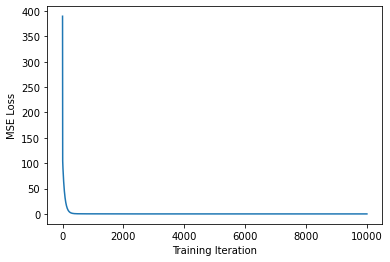

In [42]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

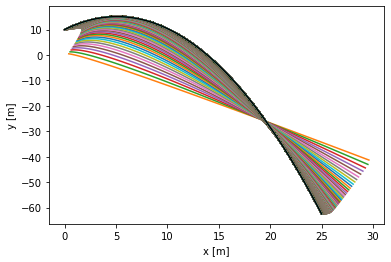

In [43]:
%matplotlib inline
for step, traj in enumerate(training_path):
    if step % 10 == 0:
        plt.plot(traj[:, 0], traj[:, 1], label=f'Guess {step}')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
#plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

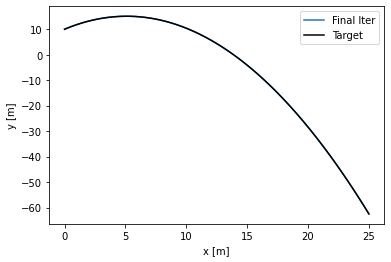

In [44]:
plt.plot(training_path[-1][:, 0], training_path[-1][:, 1], label='Final Iter')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

In [45]:
print(f'Final v0: {v0_guess.detach()[0]}, Target: {v0_target[0]}')
print(f'Final x0: {x0_guess.detach()[0]}, Target: {x0_target[0]}')
print(f'Final a: {a_guess.detach()[0]}, Target: {a_target[0]}')

Final v0: tensor([4.9961, 9.9978]), Target: tensor([ 5, 10])
Final x0: tensor([4.1952e-03, 1.0002e+01]), Target: tensor([ 0, 10])
Final a: tensor([ 1.3894e-03, -9.7992e+00]), Target: tensor([ 0.0000, -9.8000])


## Learning rates and convergence

Let's try using the learning rate that we started out with. The loop:

In [46]:
# Initialize training parameters. This time we want gradients for a, x0, and v0
a_guess = torch.tensor([0., 0.])[None, :]
x0_guess = torch.tensor([0.,0.])[None, :]
v0_guess = torch.tensor([0., 0.])[None, :]

a_guess.requires_grad = True
x0_guess.requires_grad = True
v0_guess.requires_grad = True

# Learning rate -- back up to 0.1
lr = 0.1

# Keep track of training and losses 
training_path = []
losses = []

# Back to 10 updates
for epoch in range(10):   
    # Guess with current parameters
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Calculate loss
    loss = ((trajectory_target - trajectory_guess)**2).mean()
    
    # Compute gradients
    loss.backward()

    print(f"Iter {epoch}, Loss: {loss.detach().item()}")
    
    # Update for next loop -- simultaneous update of all three
    with torch.no_grad():
        v0_guess -= lr*v0_guess.grad
        x0_guess -= lr*x0_guess.grad
        a_guess -= lr*a_guess.grad

    # Zero out the gradients
    v0_guess.grad.zero_()
    x0_guess.grad.zero_()
    a_guess.grad.zero_()


    # Store training history.
    training_path.append(trajectory_guess.detach())
    losses.append(loss.detach())

Iter 0, Loss: 389.73809814453125
Iter 1, Loss: 2653.564697265625
Iter 2, Loss: 23547.7734375
Iter 3, Loss: 215280.046875
Iter 4, Loss: 1973734.125
Iter 5, Loss: 18100422.0
Iter 6, Loss: 165996688.0
Iter 7, Loss: 1522338304.0
Iter 8, Loss: 13961207808.0
Iter 9, Loss: 128036773888.0


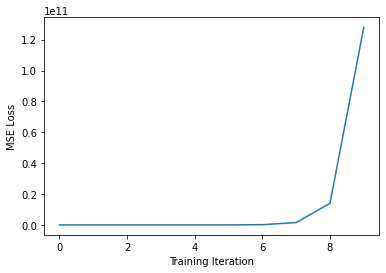

In [47]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

### Uh oh, the loss should be going down!

Usually when this happens, the learning rate is too big -- the optimization procedure doesn't converge to a minimum because we're "bouncing around" the parameter space.

#### Solutions:
1. Guess and check: try decreasing learning rate. Often helpful to look at the magnitude of the corresponding gradients to get an idea of appropriate magnitudes
2. Use a better optimizer (e.g. something adaptive like Adam)

In our case, guessing should be sufficient. Note that _decreasing_ the size of our update steps means that we should _increase_ the number of training iterations.

## Cleaning up
We've manually defined our loss function and optimizer, but using built in PyTorch stuff generalizes much better! Rewriting:

In [48]:
# Same MSE loss from PyTorch
loss_fn = torch.nn.MSELoss()

# If we want to initialize at 0's we should use torch.zeros
a_guess = torch.zeros((1, 2), requires_grad=True)
x0_guess = torch.zeros((1, 2), requires_grad=True)
v0_guess = torch.zeros((1, 2), requires_grad=True)

# Torch has a bunch of built in optimizers. Stick with gradient descent.
optimizer = torch.optim.SGD([a_guess, x0_guess, v0_guess], lr=0.01)

# Same simple history tracking
training_path = []
losses = []
for epoch in tqdm(range(10000)):
    # This line replaces the per-parameter gradient zeroing
    optimizer.zero_grad()
    
    # Forward model done the same way
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Pass to loss function
    loss = loss_fn(trajectory_target, trajectory_guess)
    
    # Backward pass done the same way
    loss.backward()

    # The optimizer takes care of the gradient steps
    optimizer.step()
        
    losses.append(loss.detach())
    training_path.append(trajectory_guess.detach())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4897.53it/s]


Results are completely identical

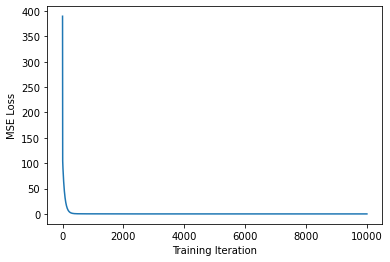

In [49]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

In [50]:
print(losses[-1])

tensor(1.4415e-06)


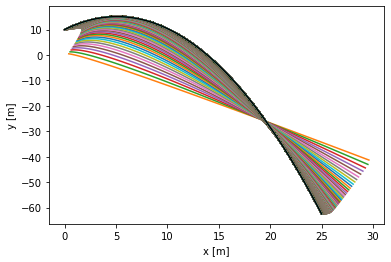

In [51]:
%matplotlib inline
for step, traj in enumerate(training_path):
    if step % 10 == 0:
        plt.plot(traj[:, 0], traj[:, 1], label=f'Guess {step}')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
#plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

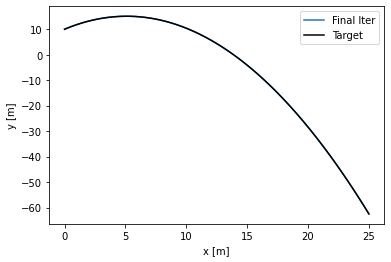

In [52]:
plt.plot(training_path[-1][:, 0], training_path[-1][:, 1], label='Final Iter')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

In [53]:
print(f'Final v0: {v0_guess.detach()[0]}, Target: {v0_target[0]}')
print(f'Final x0: {x0_guess.detach()[0]}, Target: {x0_target[0]}')
print(f'Final a: {a_guess.detach()[0]}, Target: {a_target[0]}')

Final v0: tensor([4.9961, 9.9978]), Target: tensor([ 5, 10])
Final x0: tensor([4.1952e-03, 1.0002e+01]), Target: tensor([ 0, 10])
Final a: tensor([ 1.3894e-03, -9.7992e+00]), Target: tensor([ 0.0000, -9.8000])


## Conclusions:

We have constructed a simple physics model with PyTorch and used automatic differentiation to fit parameters of that model via gradient descent, given target data. The model we use here is very simple, but a very similar training loop can be used for much more complex physics models and many more parameters -- the important thing is the differentiability!


### Context:

The problem that we solved today can be viewed in two ways:
1. The forward model, $\phi$ is a map from parameters $\theta$ to trajectories $X$. We can use automatic differentiation to invert this map: given $X$ and $\phi$, we can reconstruct $\theta$.
2. Our initial parameters are parameters of our simulation, and are our best guesses at what the parameters are in real life. We've now been given some data that we believe obeys the physics of our model. We can then fit the model parameters to _calibrate_ the simulation to the data.

Keep these two contexts in mind for your experiments! The approach we demonstrated above works for both :)